In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import nfl_data_py as nfl

In [2]:
#Download every available years worth of play by play, weekly, injury, and season information

#pbp_df contains play by play data which is aggregated to produce weekly player stats
pbp_df = pd.DataFrame(nfl.import_pbp_data([2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010]))#,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999]))

#weekly_df contains data from the import_weekly_data() endpoint and is used to grab the player's active team
weekly_df = pd.DataFrame(nfl.import_weekly_data([2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010]))#,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999]))

#injuries_df contains weekly injury data which will be merged with each position df to provide a count of positions that are injured on each side of the ball
injuries_df = pd.DataFrame(nfl.import_injuries([2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010]))#,2009]))

#schedules_df contains defensive data used for strength metrics
schedules_df = pd.DataFrame(nfl.import_schedules([2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010]))#,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999]))


2024 done.
2023 done.
2022 done.
2021 done.
2020 done.
2019 done.
2018 done.
2017 done.
2016 done.
2015 done.
2014 done.
2013 done.
2012 done.
2011 done.
2010 done.
Downcasting floats.
Downcasting floats.


In [5]:
#Checking the columns in play by play
weekly_df.columns

Index(['player_id', 'player_name', 'player_display_name', 'position',
       'position_group', 'headshot_url', 'recent_team', 'season', 'week',
       'season_type', 'opponent_team', 'completions', 'attempts',
       'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards',
       'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',
       'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
       'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards',
       'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
       'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions',
       'receptions', 'targets', 'receiving_yards', 'receiving_tds',
       'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
       'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
       'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
       'wopr', 'special_teams_tds', 'fantasy_points

In [6]:
#kicking isn't as straightforward since the data doesn't have the same data points as are available with passing, rushing, and receiving:
kicker_plays = pbp_df[pbp_df['kicker_player_name'].notnull()]

# Filter out only successful field goals for longest field goal calculation
made_field_goals = kicker_plays[kicker_plays['field_goal_result'] == 'made']

# Aggregate kicker statistics including longest field goal and kickoff
kicker_stats = kicker_plays.groupby(['season', 'game_id', 'game_date', 'week', 'div_game', 'home_team', 'away_team', 'weather', 'location', 'stadium',  'spread_line', 'total_line', 'roof', 'surface', 'temp', 'wind', 'home_coach', 'away_coach','kicker_player_id', 'kicker_player_name']).agg({
    'field_goal_result': lambda x: (x == 'made').sum(),  # Sum of successful field goals
    'extra_point_result': lambda x: (x == 'good').sum(),  # Sum of successful extra points
    'kick_distance': 'sum',  # Sum of kickoff yardage
    'field_goal_attempt': 'sum',  # Total field goal attempts
    'kickoff_attempt': 'sum'
}).reset_index()

# Calculate longest successful field goal using the filtered made_field_goals DataFrame
longest_fg = made_field_goals.groupby(['game_id','kicker_player_id', 'kicker_player_name'])['kick_distance'].max().reset_index()
longest_fg.rename(columns={'kick_distance': 'longest_fg'}, inplace=True)
# Merge longest field goal into kicker_stats
kicker_stats = pd.merge(kicker_stats, longest_fg, on=['game_id', 'kicker_player_id', 'kicker_player_name'], how='left')

# Rename the aggregated columns for clarity
kicker_stats.rename(columns={
    'field_goal_attempt': 'fg_attempts',
    'field_goal_result': 'fg_made',
    'longest_fg': 'longest_fg',
    'extra_point_result': 'xp_made',
    'kick_distance': 'total_kick_distance'
}, inplace=True)

kicker_stats.head()

# kicker_stats.to_csv('nfl_kicker_stats_1999_2024.csv')

season          game_id   game_date  week  div_game home_team away_team  \
0    2010  2010_01_ATL_PIT  2010-09-12     1         0       PIT       ATL   
1    2010  2010_01_ATL_PIT  2010-09-12     1         0       PIT       ATL   
2    2010  2010_01_ATL_PIT  2010-09-12     1         0       PIT       ATL   
3    2010  2010_01_BAL_NYJ  2010-09-13     1         0       NYJ       BAL   
4    2010  2010_01_BAL_NYJ  2010-09-13     1         0       NYJ       BAL   

                                             weather location  \
0  Cloudy Temp: 65° F, Humidity: 67%, Wind: From ...     Home   
1  Cloudy Temp: 65° F, Humidity: 67%, Wind: From ...     Home   
2  Cloudy Temp: 65° F, Humidity: 67%, Wind: From ...     Home   
3      Temp: 67° F, Humidity: 100%, Wind: NNW 11 mph     Home   
4      Temp: 67° F, Humidity: 100%, Wind: NNW 11 mph     Home   

            stadium  ...   home_coach     away_coach kicker_player_id  \
0  Acrisure Stadium  ...  Mike Tomlin     Mike Smith       00-0020578   
1  Acrisure Stadium  ...  Mike Tomlin     Mike Smith       00-0020737   
2  Acrisure Stadium  ...  Mike Tomlin     Mike Smith       00-0023234   
3   MetLife Stadium  ...     Rex Ryan  John Harbaugh       00-0020972   
4   MetLife Stadium  ...     Rex Ryan  John Harbaugh       00-0025565   

  kicker_player_name  fg_made  xp_made total_kick_distance fg_attempts  \
0           M.Bryant        3        0               157.0         4.0   
1             J.Reed        3        0               552.0         5.0   
2           M.Koenen        0        0               207.0         0.0   
3          B.Cundiff        1        1               246.0         1.0   
4             N.Folk        3        0               345.0         3.0   

  kickoff_attempt longest_fg  
0             0.0       49.0  
1             5.0       52.0  
2             3.0        NaN  
3             3.0       25.0  
4             4.0       48.0  

[5 rows x 26 columns]

In [7]:
#Aggregating defensive performance for home and away teams
home_points = schedules_df[['game_id', 'season', 'week', 'home_team', 'away_score']].rename(
    columns={'home_team': 'team', 'away_score': 'points_allowed'}
)
home_points['adj_week'] = home_points['week']+1
home_points.head()

away_points = schedules_df[['game_id', 'season', 'week', 'away_team', 'home_score']].rename(
    columns={'away_team': 'team', 'home_score': 'points_allowed'}
)
away_points['adj_week'] = away_points['week']+1
away_points.head()

game_id  season  week team  points_allowed  adj_week
2913   2010_01_MIN_NO    2010     1  MIN            14.0         2
2914  2010_01_MIA_BUF    2010     1  MIA            10.0         2
2915  2010_01_DET_CHI    2010     1  DET            19.0         2
2916  2010_01_IND_HOU    2010     1  IND            34.0         2
2917  2010_01_DEN_JAX    2010     1  DEN            24.0         2

In [8]:
# Combine both home and dataframes
points_allowed_df = pd.concat([home_points, away_points], ignore_index=True)

# Sort by season, team, and week to calculate cumulative points allowed up to each week
points_allowed_df = points_allowed_df.sort_values(by=['season', 'team', 'week', 'adj_week'])

# Calculate cumulative points allowed for each team
points_allowed_df['cumulative_points_allowed'] = points_allowed_df.groupby(['season', 'team'])['points_allowed'].cumsum()

points_allowed_df.rename(columns={
    'team': 'defense_name'
}, inplace=True)

#Creating defensive ranking based on cumulative points
points_allowed_df['defensive_rank'] = points_allowed_df.groupby(['season', 'week'])['cumulative_points_allowed'].rank(method='min', ascending=True)

# Display the ranked defensive strength for verification
points_allowed_df.head(10)

pbp_categories = pbp_df[['season', 'game_id', 'game_date', 'week', 'div_game', 'home_team', 'away_team', 'weather', 'location', 'stadium',  'spread_line', 'total_line', 'roof', 'surface', 'temp', 'wind', 'home_coach', 'away_coach']]
pbp_categories.drop_duplicates(inplace=True)
pbp_categories.head()


/var/folders/tm/5blb3w1d4mq9z5wg19x2lzqr0000gp/T/ipykernel_3283/4207301134.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_categories.drop_duplicates(inplace=True)


season          game_id   game_date  week  div_game home_team away_team  \
0      2024  2024_01_ARI_BUF  2024-09-08     1         0       BUF       ARI   
163    2024   2024_01_BAL_KC  2024-09-05     1         0        KC       BAL   
341    2024   2024_01_CAR_NO  2024-09-08     1         1        NO       CAR   
509    2024  2024_01_DAL_CLE  2024-09-08     1         0       CLE       DAL   
700    2024  2024_01_DEN_SEA  2024-09-08     1         0       SEA       DEN   

                                               weather location  \
0    Clouds and sun with wind Temp: 61° F, Humidity...     Home   
163         Temp: 67° F, Humidity: 53%, Wind: NE 8 mph     Home   
341  Cloudy Temp: 75° F, Humidity: 64%, Wind: C 13 mph     Home   
509   Sunny Temp: 68° F, Humidity: 41%, Wind: W 15 mph     Home   
700  Mostly Cloudy Temp: 73° F, Humidity: 72%, Wind...     Home   

                             stadium  spread_line  total_line      roof  \
0                   Highmark Stadium          6.5        46.0  outdoors   
163  GEHA Field at Arrowhead Stadium          3.0        46.0  outdoors   
341                Caesars Superdome          3.5        41.5      dome   
509            Huntington Bank Field          2.5        42.0  outdoors   
700                      Lumen Field          6.5        42.0  outdoors   

       surface  temp  wind       home_coach       away_coach  
0       a_turf  61.0  20.0   Sean McDermott  Jonathan Gannon  
163      grass  67.0   8.0        Andy Reid    John Harbaugh  
341  sportturf   NaN   NaN     Dennis Allen     Dave Canales  
509      grass  69.0  17.0  Kevin Stefanski    Mike McCarthy  
700  fieldturf  65.0   7.0   Mike Macdonald      Sean Payton

In [9]:
recent_team_df = weekly_df.groupby(['season', 'week', 'player_id', 'player_name', 'recent_team', 'position']).agg({
    'completions': 'sum', 
    'attempts': 'sum',
    'passing_yards': 'sum', 
    'passing_tds': 'sum', 
    'interceptions': 'sum', 
    'sacks': 'sum',
    'carries': 'sum',
    'rushing_yards': 'sum', 
    'rushing_tds': 'sum', 
    'rushing_fumbles': 'sum', 
    'receptions': 'sum', 
    'targets': 'sum', 
    'receiving_yards': 'sum', 
    'receiving_tds': 'sum',
    'fantasy_points': 'sum',
    'fantasy_points_ppr': 'sum'}).reset_index()

recent_team_df.drop_duplicates(inplace=True)
recent_team_df.head()

season  week   player_id player_name recent_team position  completions  \
0    2010     1  00-0019596     T.Brady          NE       QB           25   
1    2010     1  00-0020531     D.Brees          NO       QB           27   
2    2010     1  00-0021429    C.Palmer         CIN       QB           34   
3    2010     1  00-0021547     A.Gates         LAC       TE            0   
4    2010     1  00-0022127    J.Witten         DAL       TE            0   

   attempts  passing_yards  passing_tds  ...  carries  rushing_yards  \
0        35          258.0            3  ...        0            0.0   
1        36          237.0            1  ...        4           -6.0   
2        50          345.0            2  ...        4            9.0   
3         0            0.0            0  ...        0            0.0   
4         0            0.0            0  ...        0            0.0   

   rushing_tds  rushing_fumbles  receptions  targets  receiving_yards  \
0            0              0.0           0        0              0.0   
1            0              0.0           0        0              0.0   
2            0              1.0           0        0              0.0   
3            0              0.0           5        6             76.0   
4            0              0.0           3        8             27.0   

   receiving_tds  fantasy_points  fantasy_points_ppr  
0              0       22.320000           22.320000  
1              0       12.880000           12.880000  
2              0       20.700001           20.700001  
3              1       13.600000           18.600000  
4              0        2.700000            5.700000  

[5 rows x 22 columns]

In [10]:
# Merge for home games
home_merge = pd.merge(
    recent_team_df,
    pbp_categories,
    how='left',
    left_on=['season', 'week', 'recent_team'],
    right_on=['season', 'week', 'home_team']
)

# Merge for away games
away_merge = pd.merge(
    recent_team_df,
    pbp_categories,
    how='left',
    left_on=['season', 'week', 'recent_team'],
    right_on=['season', 'week', 'away_team']
)

# Add a column to indicate whether the record is a home or away game
home_merge['game_location'] = 'home'
away_merge['game_location'] = 'away'

# Combine both home and away merges
merged_df = pd.concat([home_merge, away_merge], ignore_index=True)


# Fill missing values with data from the opposite game location
merged_df = merged_df.groupby(['season', 'week', 'player_id', 'player_name'], as_index=False).first()

# checking data fidelity

merged_df[merged_df['player_name'] == 'C.McCaffrey'].sort_values(['season', 'week']).head().to_csv('huh.csv')

In [11]:
_v0 = merged_df
_v0.drop_duplicates()
_v0.head()

season  week   player_id player_name recent_team position  completions  \
0    2010     1  00-0019596     T.Brady          NE       QB           25   
1    2010     1  00-0020531     D.Brees          NO       QB           27   
2    2010     1  00-0021429    C.Palmer         CIN       QB           34   
3    2010     1  00-0021547     A.Gates         LAC       TE            0   
4    2010     1  00-0022127    J.Witten         DAL       TE            0   

   attempts  passing_yards  passing_tds  ...                          stadium  \
0        35          258.0            3  ...                 Gillette Stadium   
1        36          237.0            1  ...                Caesars Superdome   
2        50          345.0            2  ...                 Gillette Stadium   
3         0            0.0            0  ...  GEHA Field at Arrowhead Stadium   
4         0            0.0            0  ...                 Commanders Field   

   spread_line  total_line      roof    surface  temp  wind      home_coach  \
0          5.0        44.5  outdoors  fieldturf  62.0  10.0  Bill Belichick   
1          4.5        48.5      dome  sportturf   NaN   NaN     Sean Payton   
2          5.0        44.5  outdoors  fieldturf  62.0  10.0  Bill Belichick   
3         -4.0        45.5  outdoors      grass  78.0  10.0      Todd Haley   
4         -3.5        39.5  outdoors      grass  66.0   2.0   Mike Shanahan   

       away_coach  game_location  
0    Marvin Lewis           home  
1  Brad Childress           home  
2    Marvin Lewis           home  
3     Norv Turner           home  
4   Wade Phillips           home  

[5 rows x 39 columns]

In [12]:
_points = schedules_df[['game_id', 'season', 'week', 'home_team', 'home_score', 'away_team', 'away_score']].rename(
    columns={'away_score': 'away_points_allowed', 'home_score': 'home_points_allowed'}
)
_points.sort_values(by=['season', 'home_team', 'away_team', 'week'])
_points.head()

game_id  season  week home_team  home_points_allowed away_team  \
2913   2010_01_MIN_NO    2010     1        NO                 14.0       MIN   
2914  2010_01_MIA_BUF    2010     1       BUF                 10.0       MIA   
2915  2010_01_DET_CHI    2010     1       CHI                 19.0       DET   
2916  2010_01_IND_HOU    2010     1       HOU                 34.0       IND   
2917  2010_01_DEN_JAX    2010     1       JAX                 24.0       DEN   

      away_points_allowed  
2913                  9.0  
2914                 15.0  
2915                 14.0  
2916                 24.0  
2917                 17.0

In [13]:
# Sort by season, team, and week to calculate cumulative points allowed up to each week
points_allowed_df = _points.sort_values(by=['season', 'home_team', 'away_team', 'week', 'week'])

# Calculate cumulative points allowed for each team
points_allowed_df['home_cumulative_points_allowed'] = points_allowed_df.groupby(['season', 'home_team'])['home_points_allowed'].cumsum()
points_allowed_df['away_cumulative_points_allowed'] = points_allowed_df.groupby(['season', 'away_team'])['away_points_allowed'].cumsum()

# points_allowed_df.rename(columns={
#     'team': 'defense_name'
# }, inplace=True)

#Creating defensive ranking based on cumulative points
points_allowed_df['home_defensive_rank'] = points_allowed_df.groupby(['season', 'week'])['home_cumulative_points_allowed'].rank(method='min', ascending=True)
points_allowed_df['away_defensive_rank'] = points_allowed_df.groupby(['season', 'week'])['away_cumulative_points_allowed'].rank(method='min', ascending=True)

# Display the ranked defensive strength for verification
points_allowed_df.head(10)



game_id  season  week home_team  home_points_allowed away_team  \
3138  2010_16_DAL_ARI    2010    16       ARI                 27.0       DAL   
3114  2010_14_DEN_ARI    2010    14       ARI                 43.0       DEN   
2984   2010_05_NO_ARI    2010     5       ARI                 30.0        NO   
2956  2010_03_OAK_ARI    2010     3       ARI                 24.0       OAK   
3052  2010_10_SEA_ARI    2010    10       ARI                 18.0       SEA   
3088   2010_12_SF_ARI    2010    12       ARI                  6.0        SF   
3099  2010_13_STL_ARI    2010    13       ARI                  6.0       STL   
3025   2010_08_TB_ARI    2010     8       ARI                 35.0        TB   
2929  2010_02_ARI_ATL    2010     2       ATL                 41.0       ARI   
3043  2010_10_BAL_ATL    2010    10       ATL                 26.0       BAL   

      away_points_allowed  home_cumulative_points_allowed  \
3138                 26.0                            27.0   
3114                 13.0                            70.0   
2984                 20.0                           100.0   
2956                 23.0                           124.0   
3052                 36.0                           142.0   
3088                 27.0                           148.0   
3099                 19.0                           154.0   
3025                 38.0                           189.0   
2929                  7.0                            41.0   
3043                 21.0                            67.0   

      away_cumulative_points_allowed  home_defensive_rank  away_defensive_rank  
3138                            26.0                  3.0                  3.0  
3114                            13.0                  5.0                  1.0  
2984                            20.0                  5.0                  1.0  
2956                            23.0                 10.0                  2.0  
3052                            36.0                 12.0                  4.0  
3088                            27.0                 10.0                  3.0  
3099                            19.0                 11.0                  2.0  
3025                            38.0                  9.0                  1.0  
2929                             7.0                  4.0                  1.0  
3043                            21.0                  4.0                  3.0

In [14]:
team_w_defense = pd.merge(_v0, points_allowed_df, how = 'left', left_on = ['game_id'], right_on = ['game_id'])
team_w_defense[team_w_defense['week_x'] == 2]

team_w_defense = team_w_defense.drop(columns=['season_y', 'week_y'])
team_w_defense.rename(columns={
    'week_x': 'week',
    'season_x': 'season',
    'home_team_x': 'home_team',
    'away_team_x':'away_team'
}, inplace=True)
team_w_defense.head()


season  week   player_id player_name recent_team position  completions  \
0    2010     1  00-0019596     T.Brady          NE       QB           25   
1    2010     1  00-0020531     D.Brees          NO       QB           27   
2    2010     1  00-0021429    C.Palmer         CIN       QB           34   
3    2010     1  00-0021547     A.Gates         LAC       TE            0   
4    2010     1  00-0022127    J.Witten         DAL       TE            0   

   attempts  passing_yards  passing_tds  ...      away_coach  game_location  \
0        35          258.0            3  ...    Marvin Lewis           home   
1        36          237.0            1  ...  Brad Childress           home   
2        50          345.0            2  ...    Marvin Lewis           home   
3         0            0.0            0  ...     Norv Turner           home   
4         0            0.0            0  ...   Wade Phillips           home   

   home_team_y  home_points_allowed  away_team_y  away_points_allowed  \
0           NE                 38.0          CIN                 24.0   
1           NO                 14.0          MIN                  9.0   
2           NE                 38.0          CIN                 24.0   
3           KC                 21.0           SD                 14.0   
4          WAS                 13.0          DAL                  7.0   

   home_cumulative_points_allowed  away_cumulative_points_allowed  \
0                            99.0                           120.0   
1                            71.0                            77.0   
2                            99.0                           120.0   
3                           134.0                           132.0   
4                            13.0                           173.0   

   home_defensive_rank  away_defensive_rank  
0                 13.0                 10.0  
1                  9.0                  6.0  
2                 13.0                 10.0  
3                 15.0                 12.0  
4                  2.0                 13.0  

[5 rows x 47 columns]

In [15]:
#checking data
team_w_defense[team_w_defense['player_name'] == 'C.McCaffrey'].sort_values(['season', 'week'], ascending = [False, False])


season  week   player_id  player_name recent_team position  \
61783    2024    11  00-0033280  C.McCaffrey          SF       RB   
61509    2024    10  00-0033280  C.McCaffrey          SF       RB   
58768    2023    22  00-0033280  C.McCaffrey          SF       RB   
58735    2023    21  00-0033280  C.McCaffrey          SF       RB   
58662    2023    20  00-0033280  C.McCaffrey          SF       RB   
...       ...   ...         ...          ...         ...      ...   
21986    2017     5  00-0033280  C.McCaffrey         CAR       RB   
21705    2017     4  00-0033280  C.McCaffrey         CAR       RB   
21380    2017     3  00-0033280  C.McCaffrey         CAR       RB   
21061    2017     2  00-0033280  C.McCaffrey         CAR       RB   
20753    2017     1  00-0033280  C.McCaffrey         CAR       RB   

       completions  attempts  passing_yards  passing_tds  ...      away_coach  \
61783            0         0            0.0            0  ...  Mike Macdonald   
61509            0         0            0.0            0  ...   Kyle Shanahan   
58768            0         0            0.0            0  ...   Kyle Shanahan   
58735            0         0            0.0            0  ...    Dan Campbell   
58662            0         0            0.0            0  ...    Matt LaFleur   
...            ...       ...            ...          ...  ...             ...   
21986            0         0            0.0            0  ...      Ron Rivera   
21705            0         0            0.0            0  ...      Ron Rivera   
21380            0         0            0.0            0  ...     Sean Payton   
21061            0         0            0.0            0  ...  Sean McDermott   
20753            0         0            0.0            0  ...      Ron Rivera   

       game_location  home_team_y  home_points_allowed  away_team_y  \
61783           home           SF                 17.0          SEA   
61509           home           TB                 20.0           SF   
58768           home           KC                 25.0           SF   
58735           home           SF                 34.0          DET   
58662           home           SF                 24.0           GB   
...              ...          ...                  ...          ...   
21986           home          DET                 24.0          CAR   
21705           home           NE                 30.0          CAR   
21380           home          CAR                 13.0           NO   
21061           home          CAR                  9.0          BUF   
20753           home           SF                  3.0          CAR   

       away_points_allowed  home_cumulative_points_allowed  \
61783                 20.0                           150.0   
61509                 23.0                           117.0   
58768                 22.0                           256.0   
58735                 31.0                           147.0   
58662                 21.0                           171.0   
...                    ...                             ...   
21986                 27.0                            85.0   
21705                 33.0                            90.0   
21380                 34.0                           149.0   
21061                  3.0                            29.0   
20753                 23.0                            13.0   

       away_cumulative_points_allowed  home_defensive_rank  \
61783                           106.0                 13.0   
61509                           100.0                 10.0   
58768                           118.0                  1.0   
58735                           228.0                  1.0   
58662                           297.0                  3.0   
...                               ...                  ...   
21986                            40.0                  7.0   
21705                            73.0                  7.0   
21380                            98.0            

In [16]:
#Grab positions from the defense_df and aggregating counts of injured players on either team
unique_positions = injuries_df['position'].unique()
unique_statuses = injuries_df['report_status'].unique()
unique_positions, unique_statuses

# Define relevant offensive and defensive positions for flag creation
offensive_positions = ['WR', 'RB', 'QB', 'TE', 'T', 'G', 'C']
defensive_positions = ['S', 'DT', 'DE', 'CB', 'LB']

# Create flags for offensive injuries
for position in offensive_positions:
    injuries_df[f'offense_injury_{position}'] = (
        (injuries_df['position'] == position) & 
        (injuries_df['report_status'].isin(['Out', 'Questionable']))
    ).astype(int)

# Create flags for defensive injuries
for position in defensive_positions:
    injuries_df[f'defense_injury_{position}'] = (
        (injuries_df['position'] == position) & 
        (injuries_df['report_status'].isin(['Out', 'Questionable']))
    ).astype(int)

# Aggregate the flags by team and week to count injuries in each category
injuries_df_v0 = injuries_df.groupby(['season', 'team', 'week']).agg({
    f'offense_injury_{position}': 'sum' for position in offensive_positions
}).join(
    injuries_df.groupby(['season','team', 'week']).agg({
        f'defense_injury_{position}': 'sum' for position in defensive_positions
    })
).reset_index()

# Display the resulting injury flags data
injuries_df_v0.head()

season team  week  offense_injury_WR  offense_injury_RB  offense_injury_QB  \
0  2010.0  ARI   1.0                  0                  2                  0   
1  2010.0  ARI   2.0                  1                  1                  0   
2  2010.0  ARI   3.0                  2                  1                  0   
3  2010.0  ARI   4.0                  2                  0                  0   
4  2010.0  ARI   5.0                  2                  0                  0   

   offense_injury_TE  offense_injury_T  offense_injury_G  offense_injury_C  \
0                  0                 0                 0                 0   
1                  0                 0                 0                 0   
2                  0                 0                 1                 0   
3                  0                 0                 0                 0   
4                  0                 0                 0                 0   

   defense_injury_S  defense_injury_DT  defense_injury_DE  defense_injury_CB  \
0                 0                  0                  0                  0   
1                 1                  0                  1                  0   
2                 0                  0                  0                  0   
3                 0                  0                  0                  0   
4                 1                  0                  1                  0   

   defense_injury_LB  
0                  0  
1                  0  
2                  1  
3                  1  
4                  0

In [17]:
defensive_inj = injuries_df_v0[['season', 'team', 'week', 'defense_injury_S', 'defense_injury_DT', 'defense_injury_DE', 'defense_injury_CB', 'defense_injury_LB']]
offensive_inj = injuries_df_v0[['season', 'team', 'week', 'offense_injury_WR', 'offense_injury_RB', 'offense_injury_QB', 'offense_injury_TE', 'offense_injury_T', 'offense_injury_G', 'offense_injury_C']]

defensive_inj.rename(columns={
    'team': 'defense_1'
}, inplace=True)

offensive_inj.rename(columns={
    'team': 'defense_2'
}, inplace=True)

defensive_inj.head()

/var/folders/tm/5blb3w1d4mq9z5wg19x2lzqr0000gp/T/ipykernel_3283/632850375.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defensive_inj.rename(columns={
/var/folders/tm/5blb3w1d4mq9z5wg19x2lzqr0000gp/T/ipykernel_3283/632850375.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offensive_inj.rename(columns={


season defense_1  week  defense_injury_S  defense_injury_DT  \
0  2010.0       ARI   1.0                 0                  0   
1  2010.0       ARI   2.0                 1                  0   
2  2010.0       ARI   3.0                 0                  0   
3  2010.0       ARI   4.0                 0                  0   
4  2010.0       ARI   5.0                 1                  0   

   defense_injury_DE  defense_injury_CB  defense_injury_LB  
0                  0                  0                  0  
1                  1                  0                  0  
2                  0                  0                  1  
3                  0                  0                  1  
4                  1                  0                  0

In [18]:
_final = team_w_defense.merge(
    defensive_inj, how='left', left_on=['season', 'home_team', 'week'], right_on=['season', 'defense_1', 'week']
).merge(
    offensive_inj, how='left', left_on=['season', 'away_team', 'week'], right_on=['season', 'defense_2', 'week'])


In [19]:
import re
_final['weather'] = _final['weather'].fillna('Unknown')
_final['weather'].apply(lambda x: 'Cloudy' if 'Cloud' in x else 
                                                                     'Sunny' if 'Sunny' in x else 
                                                                     'Rainy' if 'Rain' in x else 
                                                                     'Other')


# Function to extract weather features
def parse_weather(data):
    data['weather'] = data['weather'].fillna('Unknown')
    
    data['temperature'] = data['weather'].str.extract(r'Temp: (\d+)° F').astype(float)
    data['humidity'] = data['weather'].str.extract(r'Humidity: (\d+)%').astype(float)
    data['wind_speed'] = data['weather'].str.extract(r'Wind: [A-Z]* (\d+) mph').astype(float)
    data['weather_condition'] = data['weather'].apply(lambda x: 'Cloudy' if 'Cloud' in x else 
                                                                     'Sunny' if 'Sunny' in x else 
                                                                     'Rainy' if 'Rain' in x else 
                                                                     'Other')
    return data

# Apply parsing to all datasets
_final = parse_weather(_final)

_final = _final.drop(columns=['weather'])
_final.head()

season  week   player_id player_name recent_team position  completions  \
0    2010     1  00-0019596     T.Brady          NE       QB           25   
1    2010     1  00-0020531     D.Brees          NO       QB           27   
2    2010     1  00-0021429    C.Palmer         CIN       QB           34   
3    2010     1  00-0021547     A.Gates         LAC       TE            0   
4    2010     1  00-0022127    J.Witten         DAL       TE            0   

   attempts  passing_yards  passing_tds  ...  offense_injury_RB  \
0        35          258.0            3  ...                1.0   
1        36          237.0            1  ...                1.0   
2        50          345.0            2  ...                1.0   
3         0            0.0            0  ...                NaN   
4         0            0.0            0  ...                0.0   

   offense_injury_QB  offense_injury_TE  offense_injury_T  offense_injury_G  \
0                0.0                0.0               0.0               0.0   
1                0.0                0.0               0.0               0.0   
2                0.0                0.0               0.0               0.0   
3                NaN                NaN               NaN               NaN   
4                0.0                0.0               2.0               1.0   

   offense_injury_C  temperature  humidity  wind_speed  weather_condition  
0               0.0         62.0       NaN         NaN             Cloudy  
1               0.0         81.0      77.0         7.0             Cloudy  
2               0.0         62.0       NaN         NaN             Cloudy  
3               NaN         78.0      75.0         NaN              Other  
4               0.0         66.0      85.0         2.0             Cloudy  

[5 rows x 64 columns]

In [20]:
# Fill missing values
_final = _final.fillna({'temperature': _final['temperature'].mean(),
                                  'humidity': _final['humidity'].mean(),
                                  'wind_speed': _final['wind_speed'].mean()})

In [21]:
def calc_agg_stats_adapted(group, fields, career=True):
    # Adjusting the original calc_agg function to fit this set of data
    df = pd.DataFrame(index=group.index)
    
    group_sorted = group.sort_values(['player_id', 'season', 'game_date'])

    df['n_games_career'] = group_sorted.groupby('player_id').cumcount() + 1
    df['n_games_season'] = group_sorted.groupby(['player_id', 'season']).cumcount() + 1

    for field in fields:
        if career:
            # Career stats
            df[f'{field}_mean_career'] = group_sorted.groupby('player_id')[field].expanding().mean().reset_index(level=0, drop=True).shift()

        # Season stats
        df[f'{field}_mean_season'] = group_sorted.groupby(['player_id', 'season'])[field].expanding().mean().reset_index(level=[0, 1], drop=True).shift()

        # Last 5 games
        df[f'{field}_mean_last5'] = group_sorted.groupby('player_id')[field].transform(
            lambda x: x.rolling(window=5, min_periods=1).mean().shift()
        )

        # Last game 
        df[f'{field}_last'] = group_sorted.groupby('player_id')[field].shift()

    return df

def train_test_split_by_week(data, test_season, test_week):
    """
    Splits the data into training and testing sets based on season and week.

    Parameters:
        data (DataFrame): The dataset with season and week information.
        test_season (int): The season to reserve for testing.
        test_week (int): The week to predict, excluding this and later weeks from training.

    Returns:
        train_data, test_data
    """
    train_data = data[
        (data['season'] < test_season) |
        ((data['season'] == test_season) & (data['week'] < test_week))
    ]
    
    test_data = data[(data['season'] == test_season) & (data['week'] == test_week)]
    
    return train_data, test_data

def train_test_split_by_season(data, test_season, features, target):
    """
    Splits the dataset into training and testing sets based on seasons.

    Parameters:
        data (pd.DataFrame): The complete dataset.
        test_season (int or list): The season(s) to use for testing.
        features (list): List of feature column names.
        target (str): Target column name.

    Returns:
        X_train, X_test, y_train, y_test: Split training and testing datasets.
    """
    if isinstance(test_season, int):
        test_season = [test_season]

    # Split data into training and testing sets based on season
    train_data = data[~data['season'].isin(test_season)]  # Exclude test seasons for training
    test_data = data[data['season'].isin(test_season)]  # Include only test seasons for testing

    return train_data, test_data

def engineer_features(data):
    df = data.copy()

    # Ensure numerical columns are correctly formatted
    numeric_cols = [
        'rushing_yards', 'carries', 'targets', 'receptions', 
        'home_defensive_rank', 'away_defensive_rank', 
        'points_allowed', 'spread_line', 'wind_speed'
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Sort by player and game date to ensure temporal order
    df['game_date'] = pd.to_datetime(df['game_date'])
    df = df.sort_values(['player_id', 'game_date'])

    # 1. Performance Ratios (historical averages)
    df['rushing_yards_per_carry'] = (
        df.groupby('player_id')['rushing_yards'].shift() /
        df.groupby('player_id')['carries'].shift()
    )
    df['receptions_per_target'] = (
        df.groupby('player_id')['receptions'].shift() /
        df.groupby('player_id')['targets'].shift()
    )

    # 2. Matchup Difficulty (historical ranks only)
    df['home_matchup_difficulty'] = 1 / df['away_defensive_rank']
    df['away_matchup_difficulty'] = 1 / df['home_defensive_rank']

    # 3. Adverse Weather
    df['adverse_weather'] = (df['wind_speed'] > 15).astype(int)

    # 4. Opportunity Share (calculated up to the current game)
    df['opportunity_share'] = (
        df.groupby('player_id')['carries'].cumsum().shift() +
        df.groupby('player_id')['targets'].cumsum().shift()
    ) / (df['carries'].sum() + df['targets'].sum())

    # 5. Team Injury Score (ensure historical injury data)
    offense_injury_cols = [col for col in df.columns if 'offense_injury_' in col]
    defense_injury_cols = [col for col in df.columns if 'defense_injury_' in col]
    df['offense_injury_score'] = df[offense_injury_cols].sum(axis=1)
    df['defense_injury_score'] = df[defense_injury_cols].sum(axis=1)

    # 6. Rest Days
    df['rest_days'] = df.groupby('player_id')['game_date'].diff().dt.days.shift()

    # 7. Weekly Performance Differentials (based on past performance)
    df['rushing_yards_diff'] = (
        df.groupby('player_id')['rushing_yards'].diff().shift()
    )

    # 8. Fantasy Efficiency (historical only)
    df['fantasy_efficiency'] = (
        df.groupby('player_id')['fantasy_points'].shift() /
        (df.groupby('player_id')['carries'].shift() + df.groupby('player_id')['targets'].shift())
    )

    # Handle potential NaNs
    df.fillna(0, inplace=True)

    return df


def engineer_receiving_features(data):
    df = data.copy()

    # Ensure numerical columns are correctly formatted
    numeric_cols = [
        'receiving_yards', 'receptions', 'targets', 
        'home_defensive_rank', 'away_defensive_rank', 
        'points_allowed', 'spread_line', 'wind_speed'
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Sort by player and game date to ensure temporal order
    df['game_date'] = pd.to_datetime(df['game_date'])
    df = df.sort_values(['player_id', 'game_date'])

    # 1. Performance Ratios (historical averages)
    df['receiving_yards_per_reception'] = (
        df.groupby('player_id')['receiving_yards'].shift() /
        df.groupby('player_id')['receptions'].shift()
    )
    df['receptions_per_target'] = (
        df.groupby('player_id')['receptions'].shift() /
        df.groupby('player_id')['targets'].shift()
    )

    # Other features follow the same pattern as `engineer_features`
    df['home_matchup_difficulty'] = 1 / df['away_defensive_rank']
    df['away_matchup_difficulty'] = 1 / df['home_defensive_rank']
    df['adverse_weather'] = (df['wind_speed'] > 15).astype(int)
    df['opportunity_share'] = (
        df.groupby('player_id')['targets'].cumsum().shift() / df['targets'].sum()
    )
    df['rest_days'] = df.groupby('player_id')['game_date'].diff().dt.days.shift()
    df['receiving_yards_diff'] = (
        df.groupby('player_id')['receiving_yards'].diff().shift()
    )
    df['fantasy_efficiency'] = (
        df.groupby('player_id')['fantasy_points'].shift() /
        df.groupby('player_id')['targets'].shift()
    )
    df.fillna(0, inplace=True)

    return df

def engineer_passing_features(data):
    df = data.copy()

    # Ensure numerical columns are correctly formatted
    numeric_cols = [
        'passing_yards', 'passing_tds', 'interceptions', 
        'home_defensive_rank', 'away_defensive_rank', 
        'points_allowed', 'spread_line', 'wind_speed'
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Sort by player and game date to ensure temporal order
    df['game_date'] = pd.to_datetime(df['game_date'])
    df = df.sort_values(['player_id', 'game_date'])

    # 1. Performance Ratios (historical averages)
    df['passing_yards_per_attempt'] = (
        df.groupby('player_id')['passing_yards'].shift() /
        df.groupby('player_id')['attempts'].shift()
    )
    df['passing_tds_per_attempt'] = (
        df.groupby('player_id')['passing_tds'].shift() /
        df.groupby('player_id')['attempts'].shift()
    )

    # Follow the same leakage prevention as `engineer_features`
    df['home_matchup_difficulty'] = 1 / df['away_defensive_rank']
    df['away_matchup_difficulty'] = 1 / df['home_defensive_rank']
    df['adverse_weather'] = (df['wind_speed'] > 15).astype(int)
    df['opportunity_share'] = (
        df.groupby('player_id')['attempts'].cumsum().shift() / df['attempts'].sum()
    )
    df['rest_days'] = df.groupby('player_id')['game_date'].diff().dt.days.shift()
    df['passing_yards_diff'] = (
        df.groupby('player_id')['passing_yards'].diff().shift()
    )
    df['fantasy_efficiency'] = (
        df.groupby('player_id')['fantasy_points'].shift() /
        df.groupby('player_id')['attempts'].shift()
    )
    df.fillna(0, inplace=True)

    return df


# List of offensive metrics to aggregate
offensive_metrics = [
    'passing_yards', 'rushing_yards', 'receiving_yards', 
    'passing_tds', 'carries', 'rushing_tds', 'receiving_tds', 'targets', 'receptions', 'attempts', 'completions', 'interceptions', 'rushing_fumbles'
]

# Apply the adapted function to the user's dataset
aggregated_stats = calc_agg_stats_adapted(_final, offensive_metrics)

# Combine the aggregated stats back into the original dataset for review
full_ = pd.concat([_final, aggregated_stats], axis=1)

# Apply the feature engineering function to the rusher dataset
full_w_features = engineer_features(full_)

# Display a sample of the updated dataset
full_w_features[full_w_features['player_name'] == 'C.McCaffrey'].head(25)#.to_csv('updated_r_sample.csv')


season  week   player_id  player_name recent_team position  \
20753    2017     1  00-0033280  C.McCaffrey         CAR       RB   
21061    2017     2  00-0033280  C.McCaffrey         CAR       RB   
21380    2017     3  00-0033280  C.McCaffrey         CAR       RB   
21705    2017     4  00-0033280  C.McCaffrey         CAR       RB   
21986    2017     5  00-0033280  C.McCaffrey         CAR       RB   
22263    2017     6  00-0033280  C.McCaffrey         CAR       RB   
22568    2017     7  00-0033280  C.McCaffrey         CAR       RB   
22827    2017     8  00-0033280  C.McCaffrey         CAR       RB   
23093    2017     9  00-0033280  C.McCaffrey         CAR       RB   
23371    2017    10  00-0033280  C.McCaffrey         CAR       RB   
23960    2017    12  00-0033280  C.McCaffrey         CAR       RB   
24265    2017    13  00-0033280  C.McCaffrey         CAR       RB   
24596    2017    14  00-0033280  C.McCaffrey         CAR       RB   
24919    2017    15  00-0033280  C.McCaffrey         CAR       RB   
25230    2017    16  00-0033280  C.McCaffrey         CAR       RB   
25548    2017    17  00-0033280  C.McCaffrey         CAR       RB   
25664    2017    18  00-0033280  C.McCaffrey         CAR       RB   
26046    2018     1  00-0033280  C.McCaffrey         CAR       RB   
26355    2018     2  00-0033280  C.McCaffrey         CAR       RB   
26673    2018     3  00-0033280  C.McCaffrey         CAR       RB   
27276    2018     5  00-0033280  C.McCaffrey         CAR       RB   
27571    2018     6  00-0033280  C.McCaffrey         CAR       RB   
27848    2018     7  00-0033280  C.McCaffrey         CAR       RB   
28122    2018     8  00-0033280  C.McCaffrey         CAR       RB   
28385    2018     9  00-0033280  C.McCaffrey         CAR       RB   

       completions  attempts  passing_yards  passing_tds  ...  \
20753            0         0            0.0            0  ...   
21061            0         0            0.0            0  ...   
21380            0         0            0.0            0  ...   
21705            0         0            0.0            0  ...   
21986            0         0            0.0            0  ...   
22263            0         0            0.0            0  ...   
22568            0         0            0.0            0  ...   
22827            0         0            0.0            0  ...   
23093            0         0            0.0            0  ...   
23371            0         0            0.0            0  ...   
23960            0         0            0.0            0  ...   
24265            0         0            0.0            0  ...   
24596            0         0            0.0            0  ...   
24919            0         0            0.0            0  ...   
25230            0         0            0.0            0  ...   
25548            0         0            0.0            0  ...   
25664            0         0            0.0            0  ...   
26046            0         0            0.0            0  ...   
26355            0         0            0.0            0  ...   
26673            0         0            0.0            0  ...   
27276            0         0            0.0            0  ...   
27571            0         0            0.0            0  ...   
27848            0         0            0.0            0  ...   
28122            0         0            0.0            0  ...   
28385            0         0            0.0            0  ...   

       receptions_per_target  home_matchup_difficulty  \
20753               0.000000                 0.076923   
21061               0.714286                 0.333333   
21380               0.800000                 0.125000   
21705               0.818182                 0.111111   
21986               0.666667                 0.500000   
22263               0.714286                 0.250000   
22568               0.714286                 1.000000   
22827               0.777778                 0.076923   
23093   

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Filter relevant features for rushing performance
_features = ['season', 'week',
    'carries', 'opportunity_share', 'home_matchup_difficulty', 'away_matchup_difficulty',
    'adverse_weather', 'offense_injury_score', 'defense_injury_score',
    'rushing_yards_mean_career', 'rushing_yards_mean_season', 
    'rushing_yards_mean_last5', 'rushing_yards_last', 'receiving_yards_mean_career', 'receiving_yards_mean_season', 
    'receiving_yards_mean_last5', 'receiving_yards_last', 'passing_yards_mean_career', 'passing_yards_mean_season', 
    'passing_yards_mean_last5', 'passing_yards_last'
]

# Target: Fantasy Points (tested Rushing Yards)
target = 'fantasy_points'

# Ensure no missing values in selected features and target
_data = full_w_features[_features + [target]].dropna()

# Step 2: Train-test split by temporal alignment (earlier seasons for training)

train_data = _data[_data['season'] < _data['season'].max()]
test_data = _data[_data['season'] == _data['season'].max()]

X_train = train_data.drop(columns=[target])
y_train = train_data[target]
X_test = test_data.drop(columns=[target])
y_test = test_data[target]

# Step 3: Train a Random Forest Regressor
_model = RandomForestRegressor(random_state=42, n_estimators=100)
_model.fit(X_train, y_train)

# Step 4: Make predictions and evaluate
y_pred = _model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, rmse, mse, r2


(3.784789715693668, 5.069927981490769, 25.70416973750307, 0.4616159767496536)

In [114]:
target_ = 'fantasy_points'

_features = ['season', 'week',  'position',
    'opportunity_share', 'home_matchup_difficulty', 'away_matchup_difficulty',
    'adverse_weather', 'offense_injury_score', 'defense_injury_score', 
    'rushing_yards_mean_career', 'rushing_yards_mean_season', 
    'rushing_yards_mean_last5', 'rushing_yards_last', 'receiving_yards_mean_career', 'receiving_yards_mean_season', 
    'receiving_yards_mean_last5', 'receiving_yards_last', 'passing_yards_mean_career', 'passing_yards_mean_season', 
    'passing_yards_mean_last5', 'passing_yards_last'
]

_data = full_w_features[_features + [target_]].dropna()

train_data_, test_data_ = train_test_split_by_season(_data, test_season=2024, features=_features, target=target_)
X_train_ = train_data_.drop(columns=[target_, 'season', 'week'])
y_train_ = train_data_[target_]
X_test_ = test_data_.drop(columns=[target_, 'season', 'week'])
y_test_ = test_data_[target_]

# Select only numeric columns for training and testing
X_train_numeric_ = X_train_.select_dtypes(include=[np.number])
X_test_numeric_ = X_test_.select_dtypes(include=[np.number])

# Train the Random Forest Regressor
_model = RandomForestRegressor(random_state=42, n_estimators=100)
_model.fit(X_train_numeric_, y_train_)

# Make predictions and evaluate
y_pred_ = _model.predict(X_test_numeric_)
mae_ = mean_absolute_error(y_test_, y_pred_)
rmse_ = np.sqrt(mean_squared_error(y_test_, y_pred_))
mse_ = mean_squared_error(y_test_, y_pred_)
r2_ = r2_score(y_test_, y_pred_)

print("MAE: ", mae_,", RMSE: ", rmse_, "MSE: ", mse_)

y_train_pred_ = _model.predict(X_train_numeric_)

# Calculate RMSE for the training set
rmse_train_ = np.sqrt(mean_squared_error(y_train_, y_train_pred_))
mse_train = mean_squared_error(y_train_, y_train_pred_)

# Return both training and test RMSE for comparison
print("RSME Training: ", rmse_train_, ", RSME Test: ", rmse_, "MSE Train: ", mse_train,  "MSE Test: ", mse_, "R Squared: ", r2_)


MAE:  4.172375958233645 , RMSE:  5.482602395273632 MSE:  30.05892902466016
RSME Training:  2.1442178777377565 , RSME Test:  5.482602395273632 MSE Train:  4.597670307210208 MSE Test:  30.05892902466016 R Squared:  0.370403817428837


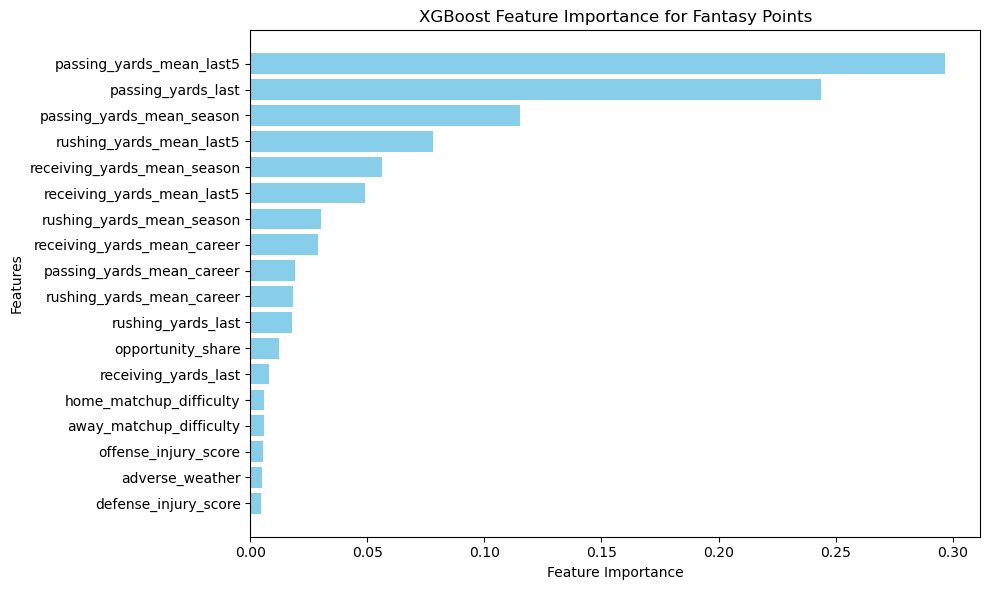

(4.0110497, 5.3761773, 0.39460933208465576)

In [50]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Initialize an XGBoost Regressor
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,  # Step size shrinkage
    n_estimators=100,   # Number of boosting rounds
    max_depth=5,        # Maximum tree depth
    subsample=0.8,      # Fraction of training data used for each tree
    colsample_bytree=0.8,  # Fraction of features used for each tree
    random_state=42
)

# Train the XGBoost model on training data
xgb_model.fit(X_train_numeric_, y_train_)

# Make predictions and evaluate the model on test data
y_pred_xgb = xgb_model.predict(X_test_numeric_)
mae_xgb = mean_absolute_error(y_test_, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_, y_pred_xgb))
r2_xgb = r2_score(y_test_, y_pred_xgb)

# Feature Importance Analysis
feature_importance = xgb_model.feature_importances_
feature_names = X_train_numeric_.columns

# Sort feature importance in descending order
sorted_idx = np.argsort(feature_importance)[::1]  # Get indices for descending sort
sorted_feature_importance = feature_importance[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance for Fantasy Points")
plt.tight_layout()
plt.show()

mae_xgb, rmse_xgb, r2_xgb


In [42]:
# Calculate feature importance directly
feature_importance = xgb_model.feature_importances_
feature_names = X_train_numeric_.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Display the top 10 features and their importance scores
top_features = importance_df.head(10)

# Evaluate the model performance
mae_xgb, rmse_xgb, top_features


(4.0110497,
 5.3761773,
                         Feature  Importance
 16     passing_yards_mean_last5    0.296875
 17           passing_yards_last    0.243951
 15    passing_yards_mean_season    0.115152
 8      rushing_yards_mean_last5    0.077972
 11  receiving_yards_mean_season    0.056399
 12   receiving_yards_mean_last5    0.048896
 7     rushing_yards_mean_season    0.030209
 10  receiving_yards_mean_career    0.028747
 14    passing_yards_mean_career    0.019039
 6     rushing_yards_mean_career    0.018297)

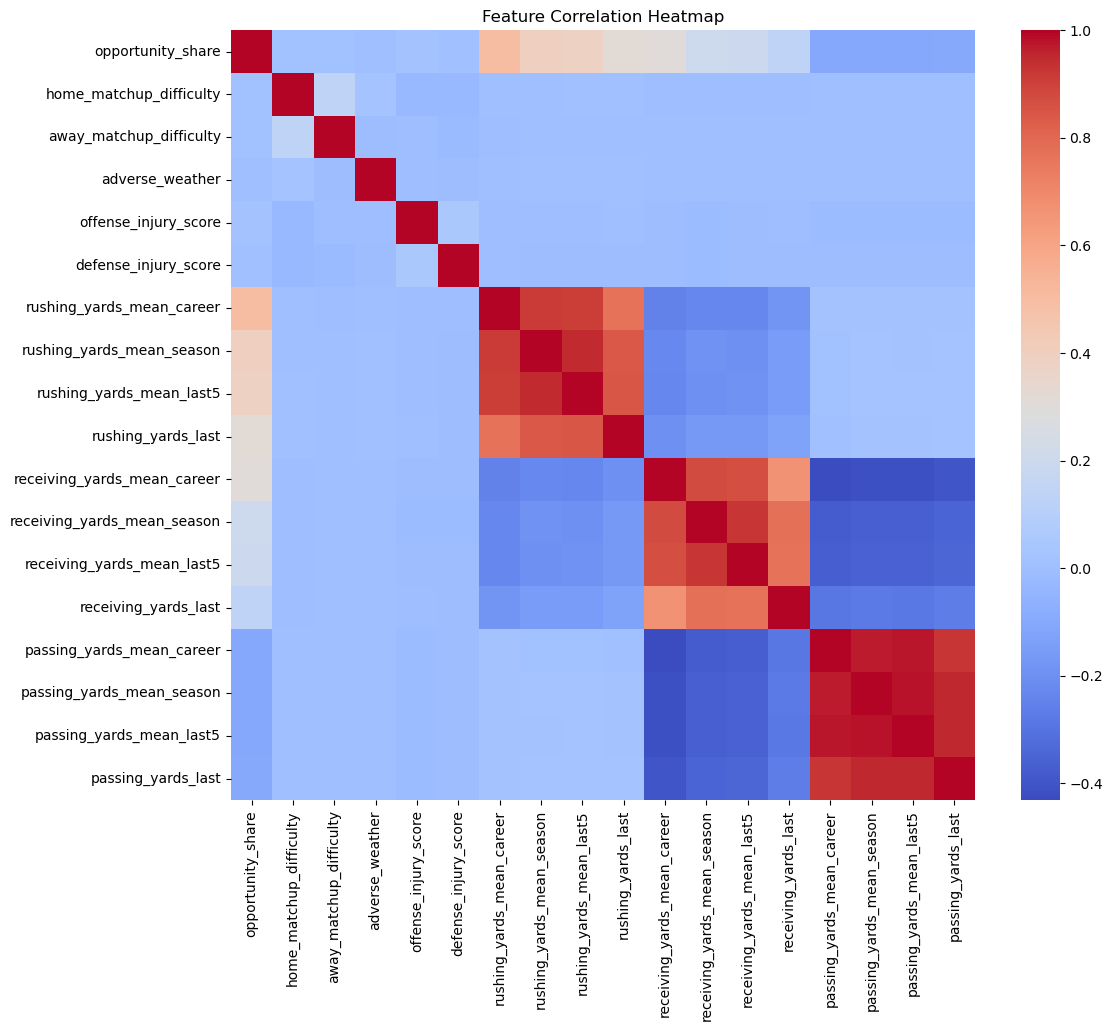

(                        Feature  Ranking
 0             opportunity_share        1
 12   receiving_yards_mean_last5        1
 11  receiving_yards_mean_season        1
 10  receiving_yards_mean_career        1
 16     passing_yards_mean_last5        1
 7     rushing_yards_mean_season        1
 8      rushing_yards_mean_last5        1
 1       home_matchup_difficulty        1
 6     rushing_yards_mean_career        1
 17           passing_yards_last        1
 2       away_matchup_difficulty        2
 13         receiving_yards_last        3
 9            rushing_yards_last        4
 14    passing_yards_mean_career        5
 5          defense_injury_score        6
 4          offense_injury_score        7
 15    passing_yards_mean_season        8
 3               adverse_weather        9,
                     Feature_1                  Feature_2  Correlation
 23   passing_yards_mean_last5  passing_yards_mean_season     0.980990
 20  passing_yards_mean_season   passing_yards_mean_last5  

In [49]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Recursive Feature Elimination (RFE)

# Initialize the Random Forest Regressor for RFE
rfe_model = RandomForestRegressor(random_state=42)
rfe = RFE(estimator=rfe_model, n_features_to_select=10)  # Select top 10 features

# Fit RFE to the training data
rfe.fit(X_train_numeric_, y_train_)

# Get the rankings of features
rfe_rankings = pd.DataFrame({
    'Feature': X_train_numeric_.columns,
    'Ranking': rfe.ranking_
}).sort_values(by='Ranking')

# Step 2: Correlation Analysis

# Compute the correlation matrix
correlation_matrix = X_train_numeric_.corr()

# Plot the heatmap to visualize correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Identify highly correlated features (correlation > 0.8 or < -0.8)
high_correlation = correlation_matrix[(correlation_matrix.abs() > 0.8) & (correlation_matrix.abs() < 1.0)]
highly_correlated_pairs = high_correlation.stack().reset_index()
highly_correlated_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
highly_correlated_pairs = highly_correlated_pairs.sort_values(by='Correlation', ascending=False)

# Display RFE rankings and highly correlated feature pairs
rfe_rankings, highly_correlated_pairs.head(10)


In [61]:
correlation_matrix = X_train_numeric.corr()

# Identify highly correlated feature pairs (absolute correlation > 0.8)
high_correlation = correlation_matrix[(correlation_matrix.abs() > 0.8) & (correlation_matrix.abs() < 1.0)]
highly_correlated_pairs = high_correlation.stack().reset_index()
highly_correlated_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
highly_correlated_pairs = highly_correlated_pairs.sort_values(by='Correlation', ascending=False)

print("Highly Correlated Pairs:")
print(highly_correlated_pairs)

features_to_drop = set(highly_correlated_pairs['Feature_2'])
X_train_refined = X_train_numeric_.drop(columns=features_to_drop)
X_test_refined = X_test_numeric_.drop(columns=features_to_drop)

refined_model = RandomForestRegressor(random_state=42)
refined_model.fit(X_train_refined, y_train_)

y_pred_refined = refined_model.predict(X_test_refined)
mae_refined = mean_absolute_error(y_test_, y_pred_refined)
rmse_refined = np.sqrt(mean_squared_error(y_test_, y_pred_refined))
r2_refined = r2_score(y_test_, y_pred_refined)

print("MAE after refinement:", mae_refined)
print("RMSE after refinement:", rmse_refined)
print("R Squared after refinement:", r2_refined)


Highly Correlated Pairs:
                      Feature_1                    Feature_2  Correlation
23     passing_yards_mean_last5    passing_yards_mean_season     0.980990
20    passing_yards_mean_season     passing_yards_mean_last5     0.980990
22     passing_yards_mean_last5    passing_yards_mean_career     0.972374
17    passing_yards_mean_career     passing_yards_mean_last5     0.972374
16    passing_yards_mean_career    passing_yards_mean_season     0.970283
19    passing_yards_mean_season    passing_yards_mean_career     0.970283
26           passing_yards_last    passing_yards_mean_season     0.953506
21    passing_yards_mean_season           passing_yards_last     0.953506
27           passing_yards_last     passing_yards_mean_last5     0.952141
24     passing_yards_mean_last5           passing_yards_last     0.952141
3     rushing_yards_mean_season     rushing_yards_mean_last5     0.949424
6      rushing_yards_mean_last5    rushing_yards_mean_season     0.949424
13  receiving

In [62]:
runs = pbp_df[pbp_df['play_type'] == 'run']
passes = pbp_df[pbp_df['play_type'] == 'pass']

red_zone_runs = runs[runs['yardline_100'] <= 20]
goal_line_runs = runs[runs['yardline_100'] <= 5]

red_zone_pass = passes[passes['yardline_100'] <= 20]
goal_line_pass = passes[passes['yardline_100'] <= 5]

red_zone_carries = red_zone_runs.groupby(['season', 'rusher_player_id', 'rusher_player_name', 'game_id', 'week']).size().reset_index(name='red_zone_carries')
goal_line_carries = goal_line_runs.groupby(['season', 'rusher_player_id', 'rusher_player_name', 'game_id', 'week']).size().reset_index(name='goal_line_carries')

red_zone_targets = red_zone_pass.groupby(['season', 'receiver_player_id', 'receiver_player_name', 'game_id', 'week']).size().reset_index(name='red_zone_targets')
goal_line_targets = goal_line_pass.groupby(['season', 'receiver_player_id', 'receiver_player_name', 'game_id', 'week']).size().reset_index(name='goal_line_targets')


goal_line_carries.head()
# red_zone_targets.head()

season rusher_player_id rusher_player_name          game_id  week  \
0    2010       00-0001231          J.Bidwell  2010_01_DAL_WAS     1   
1    2010       00-0003292          K.Collins  2010_02_PIT_TEN     2   
2    2010       00-0004161         J.Delhomme  2010_05_ATL_CLE     5   
3    2010       00-0007091       M.Hasselbeck   2010_01_SF_SEA     1   
4    2010       00-0007091       M.Hasselbeck   2010_03_SD_SEA     3   

   goal_line_carries  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1

In [63]:
goal_line_carries

season rusher_player_id rusher_player_name          game_id  week  \
0       2010       00-0001231          J.Bidwell  2010_01_DAL_WAS     1   
1       2010       00-0003292          K.Collins  2010_02_PIT_TEN     2   
2       2010       00-0004161         J.Delhomme  2010_05_ATL_CLE     5   
3       2010       00-0007091       M.Hasselbeck   2010_01_SF_SEA     1   
4       2010       00-0007091       M.Hasselbeck   2010_03_SD_SEA     3   
...      ...              ...                ...              ...   ...   
7022    2024       00-0039910          J.Daniels  2024_03_WAS_CIN     3   
7023    2024       00-0039910          J.Daniels  2024_05_CLE_WAS     5   
7024    2024       00-0039910          J.Daniels  2024_07_CAR_WAS     7   
7025    2024       00-0039918         C.Williams  2024_08_CHI_WAS     8   
7026    2024       00-0039921           T.Benson  2024_09_CHI_ARI     9   

      goal_line_carries  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  
...                 ...  
7022                  1  
7023                  1  
7024                  1  
7025                  1  
7026                  1  

[7027 rows x 6 columns]

In [64]:
red_zone_carries.sort_values(
    ['season', 'week', 'game_id', 'rusher_player_id']
)

season rusher_player_id  rusher_player_name          game_id  week  \
184      2010       00-0022736           S.Jackson  2010_01_ARI_STL     1   
706      2010       00-0026289         T.Hightower  2010_01_ARI_STL     1   
795      2010       00-0026956  L.Stephens-Howling  2010_01_ARI_STL     1   
212      2010       00-0022821            M.Turner  2010_01_ATL_PIT     1   
598      2010       00-0026163        R.Mendenhall  2010_01_ATL_PIT     1   
...       ...              ...                 ...              ...   ...   
14761    2024       00-0034844           S.Barkley  2024_11_WAS_PHI    11   
14916    2024       00-0036389             J.Hurts  2024_11_WAS_PHI    11   
14965    2024       00-0036919          K.Gainwell  2024_11_WAS_PHI    11   
15063    2024       00-0037746          B.Robinson  2024_11_WAS_PHI    11   
15270    2024       00-0039910           J.Daniels  2024_11_WAS_PHI    11   

       red_zone_carries  
184                   3  
706                   2  
795                   1  
212                   1  
598                   1  
...                 ...  
14761                 3  
14916                 4  
14965                 1  
15063                 2  
15270                 1  

[15279 rows x 6 columns]

In [65]:
#Red Zone Carries
red_zone_carries = red_zone_carries.sort_values(
    ['season', 'rusher_player_id', 'week', 'game_id']
).reset_index(drop=True)  # Reset index to avoid alignment issues

red_zone_carries['red_zone_carries_cumulative'] = (
    red_zone_carries
    .groupby(['season', 'rusher_player_id'])['red_zone_carries']
    .apply(lambda x: x.cumsum().shift().fillna(0))  # Use apply for group-wise shift
    .reset_index(drop=True)  # Reset index to align with the DataFrame
)

#Goal Line Carries
goal_line_carries = goal_line_carries.sort_values(
    ['season', 'rusher_player_id', 'week', 'game_id']
).reset_index(drop=True)

goal_line_carries['goal_line_carries_cumulative'] = (
    goal_line_carries
    .groupby(['season', 'rusher_player_id'])['goal_line_carries']
    .apply(lambda x: x.cumsum().shift().fillna(0))
    .reset_index(drop=True)
)

#Red Zone Targets
red_zone_targets = red_zone_targets.sort_values(
    ['season', 'receiver_player_id', 'week', 'game_id']
).reset_index(drop=True)

red_zone_targets['red_zone_targets_cumulative'] = (
    red_zone_targets
    .groupby(['season', 'receiver_player_id'])['red_zone_targets']
    .apply(lambda x: x.cumsum().shift().fillna(0))
    .reset_index(drop=True)
)

#Goal Line Targets
goal_line_targets = goal_line_targets.sort_values(
    ['season', 'receiver_player_id', 'week', 'game_id']
).reset_index(drop=True)

goal_line_targets['goal_line_targets_cumulative'] = (
    goal_line_targets
    .groupby(['season', 'receiver_player_id'])['goal_line_targets']
    .apply(lambda x: x.cumsum().shift().fillna(0))
    .reset_index(drop=True)
)


In [66]:
#checking data for a single player
red_zone_carries[red_zone_carries['rusher_player_id'] == '00-0035719'].sort_values(['season', 'week'])

season rusher_player_id rusher_player_name         game_id  week  \
9911     2019       00-0035719           D.Samuel  2019_08_CAR_SF     8   
9912     2019       00-0035719           D.Samuel   2019_14_SF_NO    14   
9913     2019       00-0035719           D.Samuel   2019_16_LA_SF    16   
10882    2020       00-0035719           D.Samuel   2020_07_SF_NE     7   
11893    2021       00-0035719           D.Samuel   2021_03_GB_SF     3   
11894    2021       00-0035719           D.Samuel  2021_05_SF_ARI     5   
11895    2021       00-0035719           D.Samuel   2021_10_LA_SF    10   
11896    2021       00-0035719           D.Samuel  2021_11_SF_JAX    11   
11897    2021       00-0035719           D.Samuel  2021_12_MIN_SF    12   
11898    2021       00-0035719           D.Samuel  2021_14_SF_CIN    14   
11899    2021       00-0035719           D.Samuel  2021_15_ATL_SF    15   
11900    2021       00-0035719           D.Samuel  2021_16_SF_TEN    16   
11901    2021       00-0035719           D.Samuel  2021_17_HOU_SF    17   
11902    2021       00-0035719           D.Samuel   2021_18_SF_LA    18   
11903    2021       00-0035719           D.Samuel   2021_20_SF_GB    20   
12940    2022       00-0035719           D.Samuel  2022_01_SF_CHI     1   
12941    2022       00-0035719           D.Samuel  2022_10_LAC_SF    10   
12942    2022       00-0035719           D.Samuel  2022_11_SF_ARI    11   
12943    2022       00-0035719           D.Samuel   2022_12_NO_SF    12   
12944    2022       00-0035719           D.Samuel   2022_14_TB_SF    14   
12945    2022       00-0035719           D.Samuel  2022_18_ARI_SF    18   
13952    2023       00-0035719           D.Samuel   2023_02_SF_LA     2   
13953    2023       00-0035719           D.Samuel  2023_03_NYG_SF     3   
13954    2023       00-0035719           D.Samuel  2023_05_DAL_SF     5   
13955    2023       00-0035719           D.Samuel  2023_12_SF_SEA    12   
13956    2023       00-0035719           D.Samuel  2023_13_SF_PHI    13   
13957    2023       00-0035719           D.Samuel  2023_14_SEA_SF    14   
13958    2023       00-0035719           D.Samuel  2023_21_DET_SF    21   
14855    2024       00-0035719           D.Samuel  2024_01_NYJ_SF     1   
14856    2024       00-0035719           D.Samuel  2024_02_SF_MIN     2   
14857    2024       00-0035719           D.Samuel  2024_08_DAL_SF     8   

       red_zone_carries  red_zone_carries_cumulative  
9911                  1                          0.0  
9912                  1                          1.0  
9913                  1                          2.0  
10882                 2                          0.0  
11893                 1                          0.0  
11894                 1                          1.0  
11895                 1                          2.0  
11896                 1                          3.0  
11897                 3                          4.0  
11898                 1                          7.0  
11899                 2                          8.0  
11900                 1                         10.0  
11901                 2                         11.0  
11902                 2                         13.0  
11903                 1                         15.0  
12940                 3                          0.0  
12941                 1                          3.0  
12942                 1                          4.0  
12943                 1                          5.0  
12944                 1                          6.0  
12945                 1                          7.0  
13952                 1                          0.0  
13953                 1                          1.0  
13954                 3                          2.0  
13955                 1                          5.0  
13956                 2                          6.0  
13957                 1                          8.0  
13958                 1                          9.0  
14855      

In [67]:
red_zone_carries.rename(columns={'rusher_player_id': 'player_id', 'rusher_player_name': 'player_name'}, inplace=True)
goal_line_carries.rename(columns={'rusher_player_id': 'player_id', 'rusher_player_name': 'player_name'}, inplace=True)
red_zone_targets.rename(columns={'receiver_player_id': 'player_id','receiver_player_name': 'player_name'}, inplace=True)
goal_line_targets.rename(columns={'receiver_player_id': 'player_id', 'receiver_player_name': 'player_name'}, inplace=True)

red_zone_carries = red_zone_carries.drop(columns=['player_name'], errors='ignore')

# Repeat for other DataFrames if necessary
goal_line_carries = goal_line_carries.drop(columns=['player_name'], errors='ignore')
red_zone_targets = red_zone_targets.drop(columns=['player_name'], errors='ignore')
goal_line_targets = goal_line_targets.drop(columns=['player_name'], errors='ignore')


In [68]:
#Merge the red zone and goal line dataframes into dwf_
dwf_ = pd.merge(
    full_w_features,
    red_zone_carries,
    how='left',
    on=['season', 'week', 'game_id', 'player_id']
)

dwf_ = pd.merge(
    dwf_,
    goal_line_carries,
    how='left',
    on=['season', 'week', 'game_id', 'player_id']
)

dwf_ = pd.merge(
    dwf_,
    red_zone_targets,
    how='left',
    on=['season', 'week', 'game_id', 'player_id']
)

dwf_ = pd.merge(
    dwf_,
    goal_line_targets,
    how='left',
    on=['season', 'week', 'game_id', 'player_id']
)

dwf_.fillna({
    'red_zone_carries': 0,
    'goal_line_carries': 0,
    'red_zone_targets': 0,
    'goal_line_targets': 0
}, inplace=True)

# Validate the final dataset
print(dwf_.info())
print(dwf_.head())

#checking data
dwf_[dwf_['player_name'] == 'C.McCaffrey']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62019 entries, 0 to 62018
Columns: 137 entries, season to goal_line_targets_cumulative
dtypes: datetime64[ns](1), float32(18), float64(86), int32(10), int64(3), object(19)
memory usage: 58.2+ MB
None
   season  week   player_id player_name recent_team position  completions  \
0    2010     1  00-0019596     T.Brady          NE       QB           25   
1    2010     2  00-0019596     T.Brady          NE       QB           20   
2    2010     3  00-0019596     T.Brady          NE       QB           21   
3    2010     4  00-0019596     T.Brady          NE       QB           19   
4    2010     6  00-0019596     T.Brady          NE       QB           27   

   attempts  passing_yards  passing_tds  ...  rushing_yards_diff  \
0        35          258.0            3  ...                 0.0   
1        36          248.0            2  ...                 0.0   
2        27          252.0            3  ...                 0.0   
3        24    

season  week   player_id  player_name recent_team position  \
38179    2017     1  00-0033280  C.McCaffrey         CAR       RB   
38180    2017     2  00-0033280  C.McCaffrey         CAR       RB   
38181    2017     3  00-0033280  C.McCaffrey         CAR       RB   
38182    2017     4  00-0033280  C.McCaffrey         CAR       RB   
38183    2017     5  00-0033280  C.McCaffrey         CAR       RB   
...       ...   ...         ...          ...         ...      ...   
38274    2023    20  00-0033280  C.McCaffrey          SF       RB   
38275    2023    21  00-0033280  C.McCaffrey          SF       RB   
38276    2023    22  00-0033280  C.McCaffrey          SF       RB   
38277    2024    10  00-0033280  C.McCaffrey          SF       RB   
38278    2024    11  00-0033280  C.McCaffrey          SF       RB   

       completions  attempts  passing_yards  passing_tds  ...  \
38179            0         0            0.0            0  ...   
38180            0         0            0.0            0  ...   
38181            0         0            0.0            0  ...   
38182            0         0            0.0            0  ...   
38183            0         0            0.0            0  ...   
...            ...       ...            ...          ...  ...   
38274            0         0            0.0            0  ...   
38275            0         0            0.0            0  ...   
38276            0         0            0.0            0  ...   
38277            0         0            0.0            0  ...   
38278            0         0            0.0            0  ...   

       rushing_yards_diff  fantasy_efficiency  red_zone_carries  \
38179                -1.0            0.000000               1.0   
38180                 0.0            0.325000               2.0   
38181               -37.0            0.338462               1.0   
38182                 6.0            0.780000               1.0   
38183                 0.0            0.408333               0.0   
...                   ...                 ...               ...   
38274               -39.0            0.478947               2.0   
38275                34.0            0.855172               3.0   
38276                -8.0            1.008000               4.0   
38277               -10.0            0.666667               1.0   
38278               -41.0            0.535000               3.0   

       red_zone_carries_cumulative  goal_line_carries  \
38179                          0.0                0.0   
38180                          1.0                0.0   
38181                          3.0                0.0   
38182                          4.0                0.0   
38183                          NaN                0.0   
...                            ...                ...   
38274                         65.0                0.0   
38275                         67.0                3.0   
38276                         70.0                0.0   
38277                          0.0                0.0   
38278                          1.0                0.0   

       goal_line_carries_cumulative  red_zone_targets  \
38179                           NaN               0.0   
38180                           NaN               1.0   
38181                           NaN               1.0   
38182                           NaN               1.0   
38183                           NaN               2.0   
...                             ...               ...   
38274                           NaN               1.0   
38275                          18.0               0.0   
38276                           NaN               0.0   
38277                           NaN               1.0   
38278                           NaN               1.0   

       red_zone_targets_cumulative  goal_line_targets  \
38179                          NaN                0.0   
38180                          0.0                1.0   
38181                          1.0                0

In [134]:
target_ = 'fantasy_points'

_features = ['season', 'week', 'position',
    'carries', 'opportunity_share', 'home_matchup_difficulty', 'away_matchup_difficulty',
    'adverse_weather', 'offense_injury_score', 'defense_injury_score', 
    'rushing_yards_mean_career', 'rushing_yards_mean_season', 'red_zone_carries', 'red_zone_targets', 'goal_line_carries', 'goal_line_targets',
    'rushing_yards_mean_last5', 'rushing_yards_last',  'receiving_yards_mean_career', 'receiving_yards_mean_season', 
    'receiving_yards_mean_last5', 'receiving_yards_last', 'passing_yards_mean_career', 'passing_yards_mean_season', 
    'passing_yards_mean_last5', 'passing_yards_last'
]

dwf_[_features + [target_]].dropna()


season  week position  carries  opportunity_share  \
0        2010     1       QB        0           0.000000   
1        2010     2       QB        0           0.000000   
2        2010     3       QB        4           0.000000   
3        2010     4       QB        5           0.000011   
4        2010     6       QB        2           0.000024   
...       ...   ...      ...      ...                ...   
62014    2024     4       RB        9           0.000047   
62015    2024     6       RB        5           0.000071   
62016    2024     8       RB        1           0.000084   
62017    2024     9       RB        8           0.000087   
62018    2024    10       RB       10           0.000111   

       home_matchup_difficulty  away_matchup_difficulty  adverse_weather  \
0                     0.100000                 0.076923                0   
1                     0.076923                 0.083333                0   
2                     0.076923                 0.166667                0   
3                     0.076923                 0.142857                0   
4                     0.100000                 1.000000                0   
...                        ...                      ...              ...   
62014                 0.166667                 0.062500                0   
62015                 0.333333                 0.166667                0   
62016                 0.090909                 0.333333                0   
62017                 1.000000                 0.500000                0   
62018                 1.000000                 0.076923                0   

       offense_injury_score  defense_injury_score  ...  rushing_yards_last  \
0                       2.0                   2.0  ...                 0.0   
1                       2.0                   2.0  ...                 0.0   
2                       0.0                   1.0  ...                 0.0   
3                       2.0                   1.0  ...                 6.0   
4                       2.0                   1.0  ...                 6.0   
...                     ...                   ...  ...                 ...   
62014                   0.0                   0.0  ...                 8.0   
62015                   5.0                   3.0  ...                50.0   
62016                   1.0                   3.0  ...                26.0   
62017                   6.0                   4.0  ...                10.0   
62018                   4.0                   2.0  ...                37.0   

       receiving_yards_mean_career  receiving_yards_mean_season  \
0                         0.000000                     0.000000   
1                         0.000000                     0.000000   
2                         0.000000                     0.000000   
3                         0.000000                     0.000000   
4                         0.000000                     0.000000   
...                            ...                          ...   
62014                     4.000000                     4.000000   
62015                     3.000000                     3.000000   
62016                     2.400000                     2.400000   
62017                     2.000000                     2.000000   
62018                     4.285714                     4.285714   

       receiving_yards_mean_last5  receiving_yards_last  \
0                             0.0                   0.0   
1                             0.0                   0.0   
2                             0.0                   0.0   
3                             0.0                   0.0   
4                             0.0                   0.0   
...                           ...                   ...   
62014                         4.0                   0.0   
62015                         3.0                   0.0   
62016                         2.4                   0.0   
62017                         1.4        

In [152]:
target_ = 'fantasy_points'

_features = ['season', 'week', 'position',
    'carries', 'opportunity_share', 'home_matchup_difficulty', 'away_matchup_difficulty',
    'adverse_weather', 'offense_injury_score', 'defense_injury_score', 
    'rushing_yards_mean_career', 'rushing_yards_mean_season', 'red_zone_carries', 'red_zone_targets', 'goal_line_carries', 'goal_line_targets',
    'rushing_yards_mean_last5', 'rushing_yards_last',  'receiving_yards_mean_career', 'receiving_yards_mean_season', 
    'receiving_yards_mean_last5', 'receiving_yards_last', 'passing_yards_mean_career', 'passing_yards_mean_season', 
    'passing_yards_mean_last5', 'passing_yards_last'
]

_data = dwf_[_features + [target_]].dropna()

train_data_, test_data_ = train_test_split_by_season(_data, test_season=2024, features=_features, target=target_)

X_train_ = train_data_.drop(columns=[target_, 'season', 'week'])
y_train_ = train_data_[target_]
X_test_ = test_data_.drop(columns=[target_, 'season', 'week'])
y_test_ = test_data_[target_]

# Select only numeric columns for training and testing
X_train_numeric_ = X_train_.select_dtypes(include=[np.number])
X_test_numeric_ = X_test_.select_dtypes(include=[np.number])

_model = RandomForestRegressor(random_state=42, n_estimators=100)
_model.fit(X_train_numeric_, y_train_)

# Make predictions and evaluate
y_pred_ = _model.predict(X_test_numeric_)
mae_ = mean_absolute_error(y_test_, y_pred_)
rmse_ = np.sqrt(mean_squared_error(y_test_, y_pred_))
mse_ = mean_squared_error(y_test_, y_pred_)

print("MAE: ", mae_,", RMSE: ", rmse_, "MSE: ", mse_)

y_train_pred_ = _model.predict(X_train_numeric_)

# Calculate RMSE for the training set
rmse_train_ = np.sqrt(mean_squared_error(y_train_, y_train_pred_))
mse_train_ = mean_squared_error(y_train_, y_train_pred_)
r2 = r2_score(y_test_, y_pred_)

# Return both training and test RMSE for comparison
print("RSME Training: ", rmse_train_, ", RSME Test: ", rmse_, "MSE Train: ", mse_train_,  "MSE Test: ", mse_, "R squared: ", r2_)


MAE:  3.499601039382414 , RMSE:  4.826104533789178 MSE:  23.29128497106046
RSME Training:  1.890859106297902 , RSME Test:  4.826104533789178 MSE Train:  3.5753481598697014 MSE Test:  23.29128497106046 R squared:  0.370403817428837


In [155]:
_model.predict(X_test_numeric_)

array([ 5.9024    , 12.0292    , 12.50960002, ...,  0.53800001,
        6.73259999,  5.42699999])

In [161]:
train_data_, test_data_ = train_test_split_by_season(_data, test_season=2024, features=_features, target=target_)
list(test_data_.columns)

['season',
 'week',
 'position',
 'carries',
 'opportunity_share',
 'home_matchup_difficulty',
 'away_matchup_difficulty',
 'adverse_weather',
 'offense_injury_score',
 'defense_injury_score',
 'rushing_yards_mean_career',
 'rushing_yards_mean_season',
 'red_zone_carries',
 'red_zone_targets',
 'goal_line_carries',
 'goal_line_targets',
 'rushing_yards_mean_last5',
 'rushing_yards_last',
 'receiving_yards_mean_career',
 'receiving_yards_mean_season',
 'receiving_yards_mean_last5',
 'receiving_yards_last',
 'passing_yards_mean_career',
 'passing_yards_mean_season',
 'passing_yards_mean_last5',
 'passing_yards_last',
 'fantasy_points']

In [93]:
# Testing single player predictions:

player_id =  '00-0034857' #Josh allen #'00-0033280' #C.McCaffrey  
week_of_interest = 4  
season_of_interest = 2024  
player_name = dwf_[dwf_['player_id'] == player_id]['player_name'].unique()[0] #grabbing the player name

# Filter the test data for the specific player and week
player_week_data = dwf_[
    (dwf_['player_id'] == player_id) & 
    (dwf_['week'] == week_of_interest) & 
    (dwf_['season'] == season_of_interest)
]

# Ensure there is data for the player
if player_week_data.empty:
    print(f"No data available for player {player_name, player_id} in week {week_of_interest}, season {season_of_interest}.")
else:
    # Prepare the features for prediction
    X_player_week = player_week_data[X_train_numeric_.columns]  # Match training features

    # Predict fantasy points for the player
    predicted_fantasy_points = _model.predict(X_player_week)

    # Output the results
    print(f"Predicted fantasy points for player {player_name, player_id} in week {week_of_interest}: {predicted_fantasy_points[0]:.2f}")


Predicted fantasy points for player ('J.Allen', '00-0034857') in week 4: 16.31


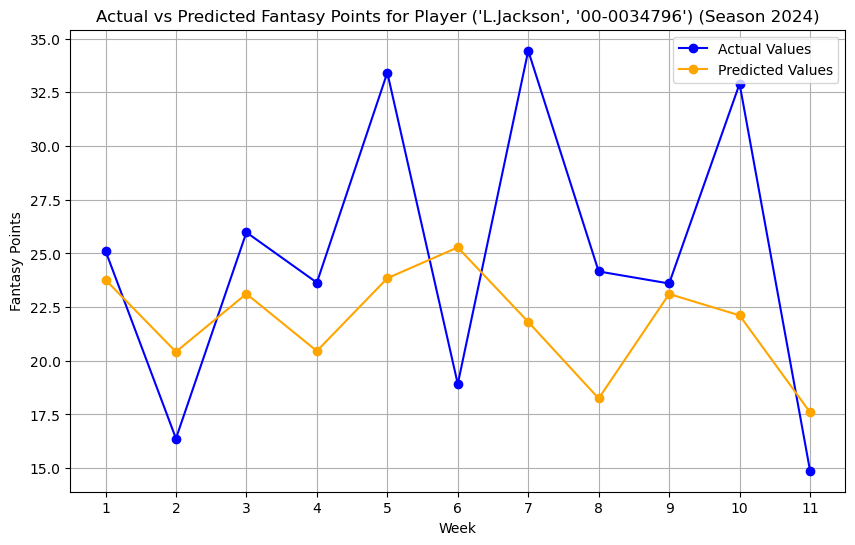

In [95]:
#Plotting single player actuals vs predicted values
import matplotlib.pyplot as plt

# Define the player and season of interest
player_id = '00-0034796' #'00-0034857' #'00-0035719' # # '00-0034857' # '00-0033280' # # Replace with the actual player ID
season_of_interest = 2024  # Replace with the season of interest
player_name = dwf_[dwf_['player_id'] == player_id]['player_name'].unique()[0]


# Filter the dataset for the player and season
player_season_data = dwf_[
    (dwf_['player_id'] == player_id) &
    (dwf_['season'] == season_of_interest)
]

if player_season_data.empty:
    print(f"No data available for player {player_name, player_id} in season {season_of_interest}.")
else:
    # Prepare features for prediction
    X_player_season = player_season_data[X_train_numeric_.columns]
    actual_values = player_season_data[target_]  # Actual fantasy points

    # Make predictions
    predicted_values = _model.predict(X_player_season)

    # Extract week numbers for the x-axis
    weeks = player_season_data['week']

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(weeks, actual_values, label='Actual Values', marker='o', color='blue')
    plt.plot(weeks, predicted_values, label='Predicted Values', marker='o', color='orange')

    # Add titles and labels
    plt.title(f"Actual vs Predicted Fantasy Points for Player {player_name, player_id} (Season {season_of_interest})")
    plt.xlabel('Week')
    plt.ylabel('Fantasy Points')
    plt.xticks(weeks)  # Ensure all weeks are shown on the x-axis
    plt.legend()
    plt.grid()
    plt.show()


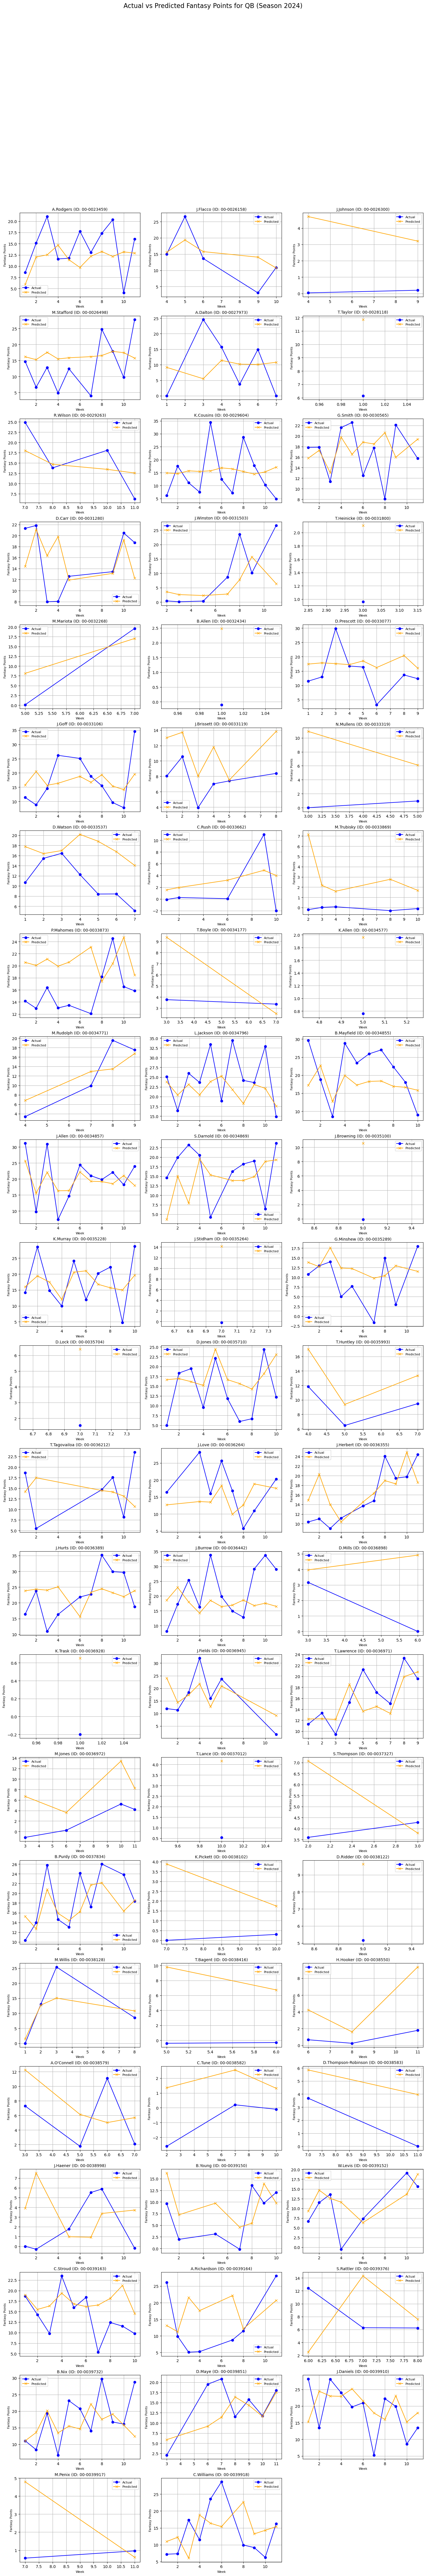

In [97]:
# Filter the dataset for the position
position_of_interest = 'QB'
position_data = dwf_[
    (dwf_['season'] == season_of_interest) &
    (dwf_['position'] == position_of_interest)
]

if position_data.empty:
    print(f"No data available for position {position_of_interest} in season {season_of_interest}.")
else:
    # Get unique player IDs for the filtered position
    player_ids = position_data['player_id'].unique()

    # Determine grid size for subplots
    import math
    n_players = len(player_ids)
    n_cols = 3
    n_rows = math.ceil(n_players / n_cols)

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten()  # Flatten for easier indexing

    for i, player_id in enumerate(player_ids):
        # Filter data for the player
        player_data = dwf_[
            (dwf_['player_id'] == player_id) &
            (dwf_['season'] == season_of_interest) &
            (dwf_['position'] == position_of_interest)
        ]
        player_name = player_data['player_name'].iloc[0]  # Get player name
        weeks = player_data['week']  # Extract weeks
        actual_values = player_data[target_]  # Actual fantasy points

        # Dynamically compute predicted values
        X_player = player_data[X_train_numeric_.columns]  # Use same features as training
        predicted_values = _model.predict(X_player)  # Generate predictions for the player

        # Plot actual and predicted values
        ax = axes[i]
        ax.plot(weeks, actual_values, label='Actual', marker='o', color='blue')
        ax.plot(weeks, predicted_values, label='Predicted', marker='x', color='orange')
        ax.set_title(f"{player_name} (ID: {player_id})", fontsize=10)
        ax.set_xlabel('Week', fontsize=8)
        ax.set_ylabel('Fantasy Points', fontsize=8)
        ax.legend(fontsize=8)
        ax.grid()

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add title and adjust layout
    fig.suptitle(f"Actual vs Predicted Fantasy Points for {position_of_interest} (Season {season_of_interest})", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


/var/folders/tm/5blb3w1d4mq9z5wg19x2lzqr0000gp/T/ipykernel_3283/218103915.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_data['total_fantasy_points'] = position_data.groupby('player_id')[target_].transform('sum')


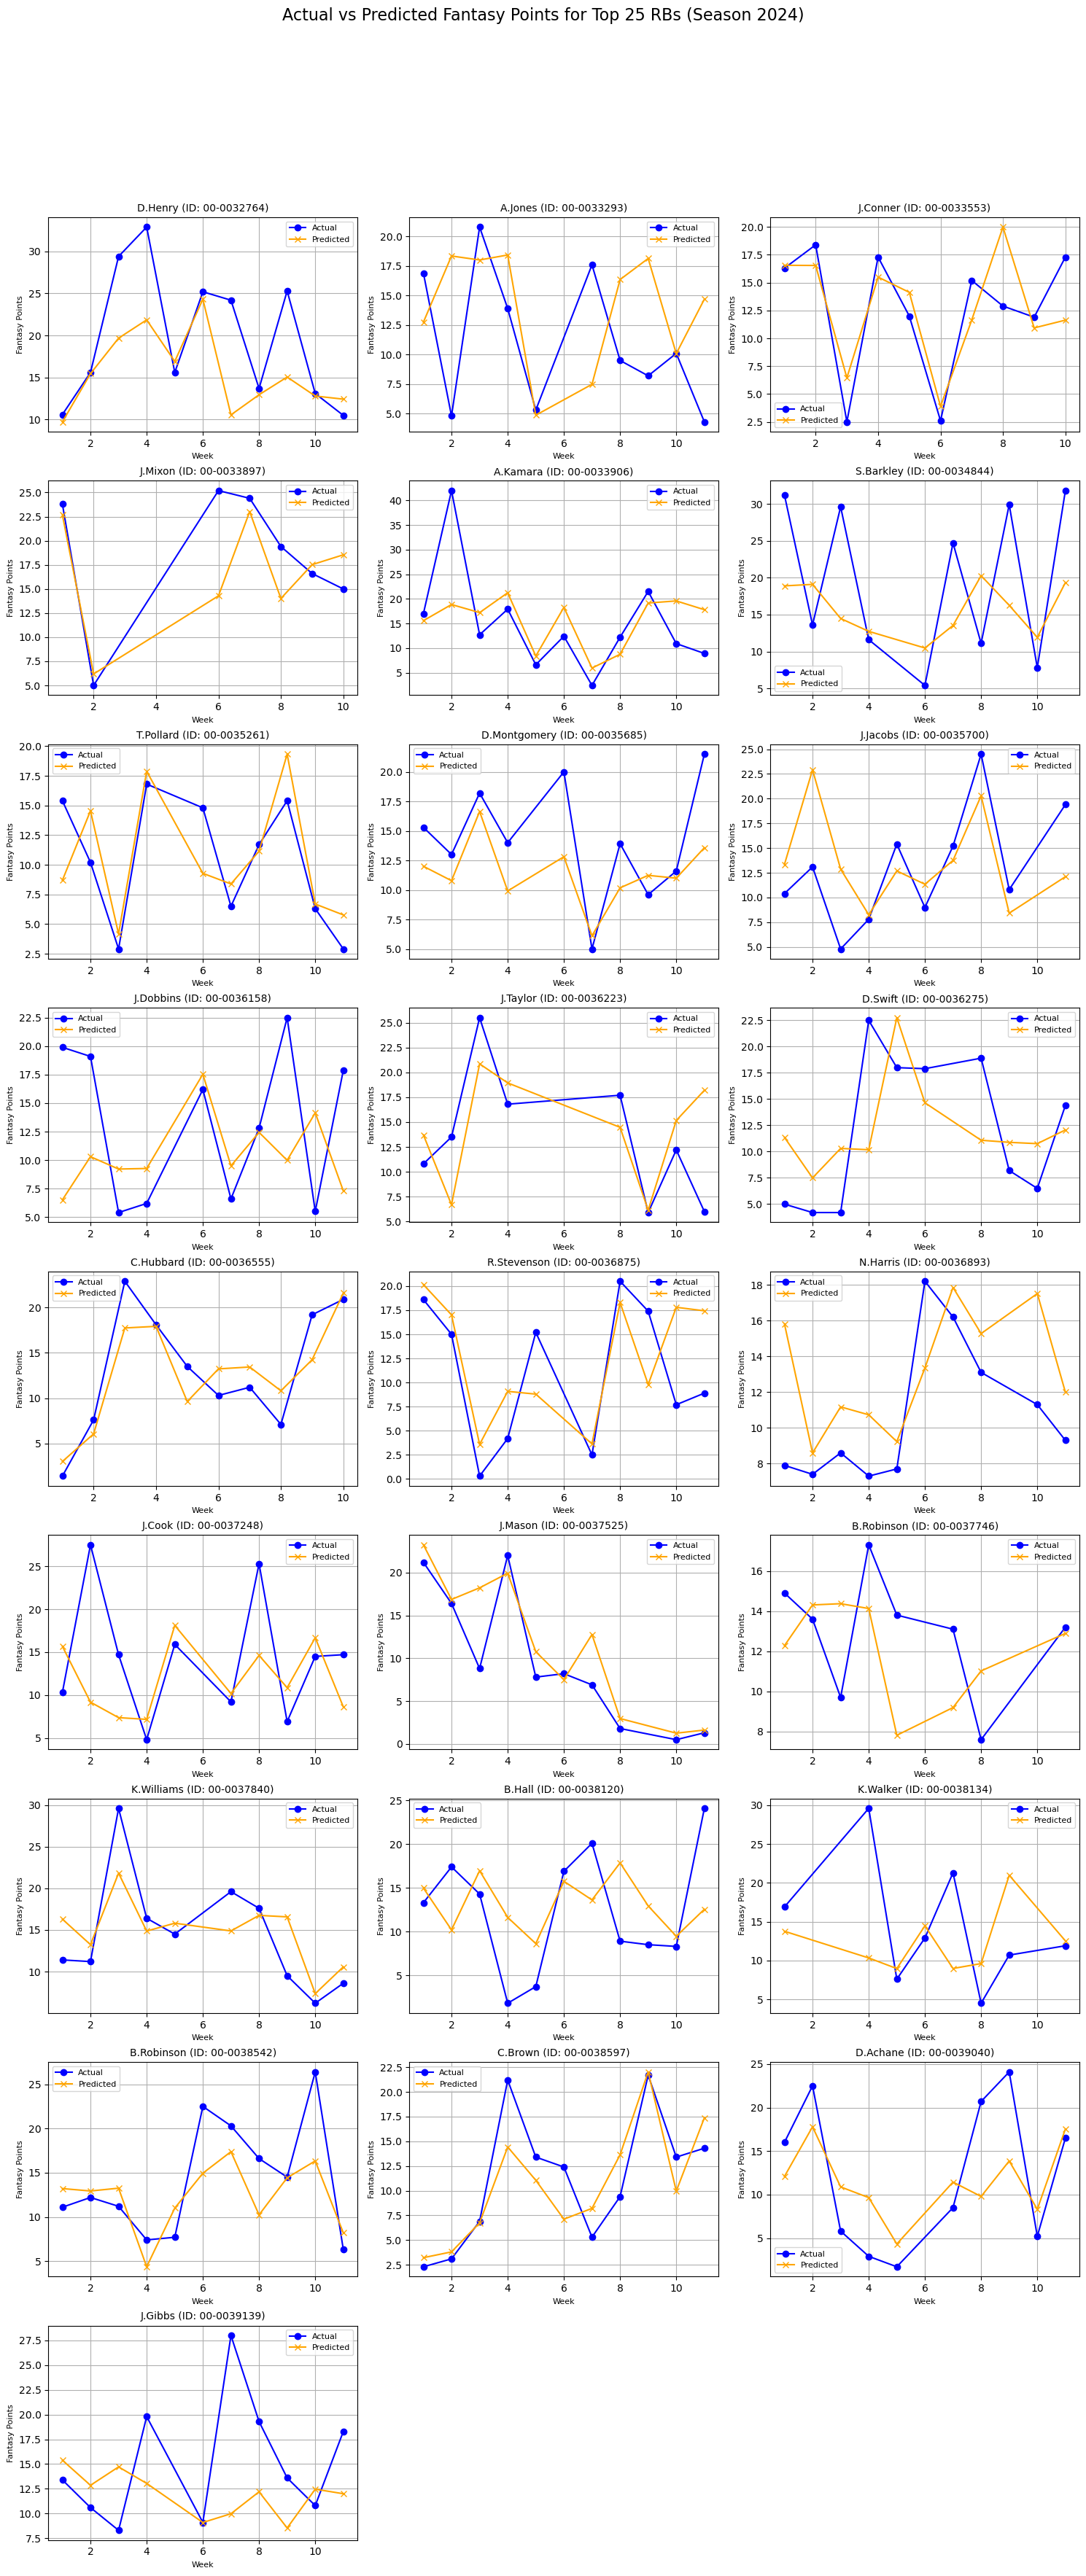

In [99]:
# Rank players by total fantasy points
top_n = 25
position_of_interest = 'RB'  # Replace with the desired position ('QB', 'RB', 'WR', etc.)
season_of_interest = 2024  # Replace with the desired season

# Filter data for the position and season
position_data = dwf_[
    (dwf_['season'] == season_of_interest) &
    (dwf_['position'] == position_of_interest)
]

if position_data.empty:
    print(f"No data available for position {position_of_interest} in season {season_of_interest}.")
else:
    # Compute total fantasy points for each player and get top 25
    position_data['total_fantasy_points'] = position_data.groupby('player_id')[target_].transform('sum')
    top_25_players = position_data.groupby('player_id')['total_fantasy_points'].max().nlargest(top_n).index

    # Filter data for the top 25 players
    top_position_data = position_data[position_data['player_id'].isin(top_25_players)]

    # Get unique player IDs for the top 25
    player_ids = top_position_data['player_id'].unique()

    # Determine grid size for subplots
    import math
    n_players = len(player_ids)
    n_cols = 3
    n_rows = math.ceil(n_players / n_cols)

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten()  # Flatten for easier indexing

    for i, player_id in enumerate(player_ids):
        # Filter data for the player
        player_data = top_position_data[top_position_data['player_id'] == player_id]
        player_name = player_data['player_name'].iloc[0]  # Get player name
        weeks = player_data['week']  # Extract weeks
        actual_values = player_data[target_]  # Actual fantasy points

        # Dynamically compute predicted values
        X_player = player_data[X_train_numeric_.columns]  # Use same features as training
        predicted_values = _model.predict(X_player)  # Generate predictions for the player

        # Plot actual and predicted values
        ax = axes[i]
        ax.plot(weeks, actual_values, label='Actual', marker='o', color='blue')
        ax.plot(weeks, predicted_values, label='Predicted', marker='x', color='orange')
        ax.set_title(f"{player_name} (ID: {player_id})", fontsize=10)
        ax.set_xlabel('Week', fontsize=8)
        ax.set_ylabel('Fantasy Points', fontsize=8)
        ax.legend(fontsize=8)
        ax.grid()

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add title and adjust layout
    fig.suptitle(f"Actual vs Predicted Fantasy Points for Top {top_n} {position_of_interest}s (Season {season_of_interest})", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


/var/folders/tm/5blb3w1d4mq9z5wg19x2lzqr0000gp/T/ipykernel_3283/1938726209.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_data['predicted_fantasy_points'] = predicted_values  # Add predictions to the DataFrame
/var/folders/tm/5blb3w1d4mq9z5wg19x2lzqr0000gp/T/ipykernel_3283/1938726209.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


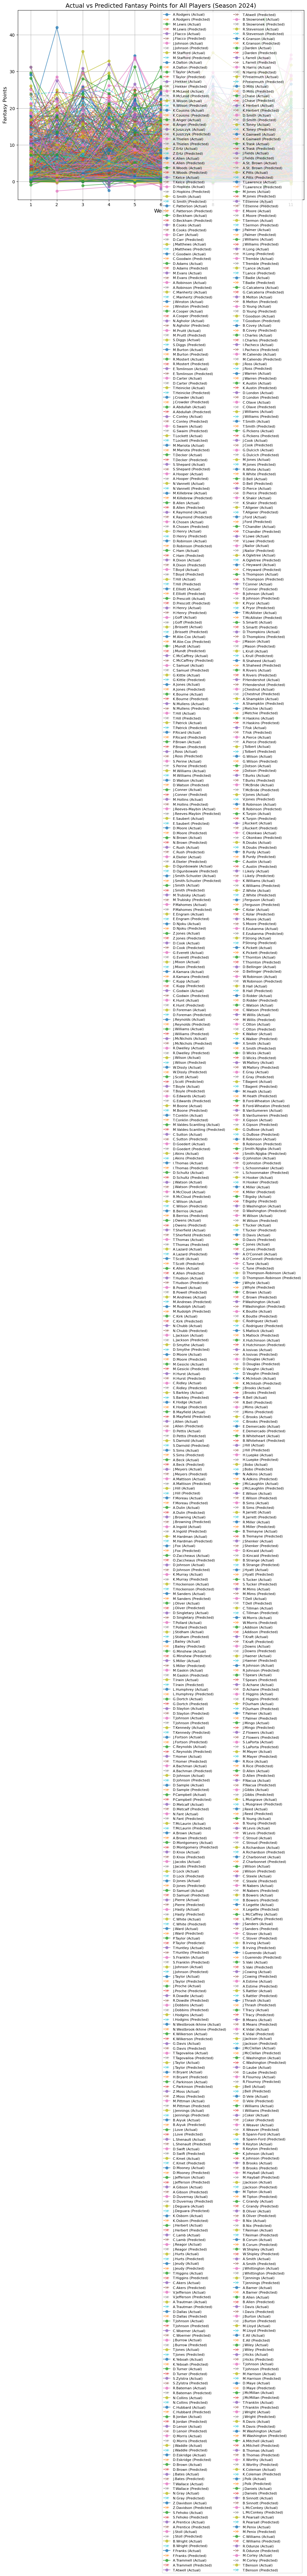

In [101]:
# Filter the dataset for the season of interest
season_of_interest = 2024
season_data = dwf_[dwf_['season'] == season_of_interest]

# Make predictions for the entire dataset
X_season = season_data[X_train_numeric_.columns]
predicted_values = _model.predict(X_season)
season_data['predicted_fantasy_points'] = predicted_values  # Add predictions to the DataFrame

# Group by player
grouped = season_data.groupby('player_id')

# Plot actual vs predicted for all players
plt.figure(figsize=(12, 8))

for player_id, data in grouped:
    player_name = data['player_name'].iloc[0]  # Get player name
    weeks = data['week']
    actual_values = data[target_]  # Replace `target_` with actual column name
    predicted_values = data['predicted_fantasy_points']

    # Plot actual and predicted values for the player
    plt.plot(weeks, actual_values, label=f'{player_name} (Actual)', linestyle='-', marker='o', alpha=0.7)
    plt.plot(weeks, predicted_values, label=f'{player_name} (Predicted)', linestyle='--', marker='x', alpha=0.7)

# Add title, labels, and legend
plt.title(f"Actual vs Predicted Fantasy Points for All Players (Season {season_of_interest})", fontsize=14)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Fantasy Points', fontsize=12)
plt.xticks(sorted(season_data['week'].unique()))  # Ensure all weeks are shown on the x-axis
plt.legend(loc='best', fontsize=8, ncol=2)  # Adjust legend size and position
plt.grid()
plt.tight_layout()
plt.show()



/var/folders/tm/5blb3w1d4mq9z5wg19x2lzqr0000gp/T/ipykernel_3283/3539221457.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


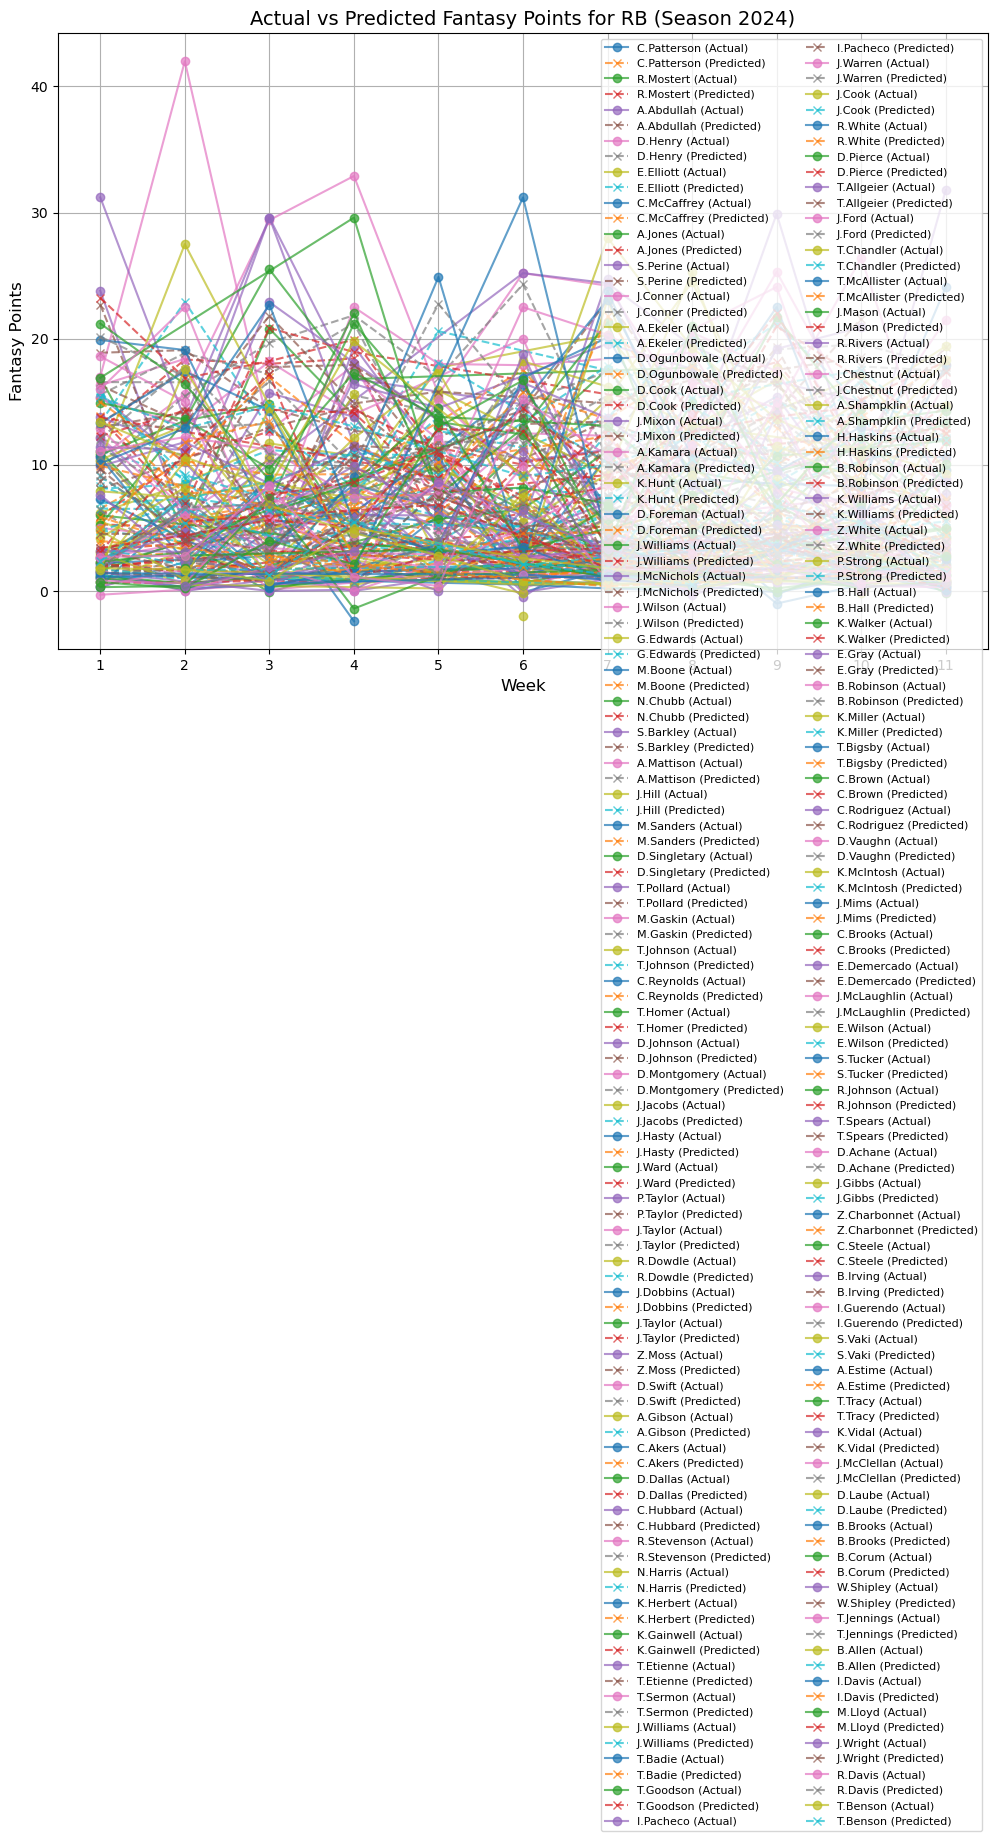

In [103]:
# Specify the position to filter
position_of_interest = 'RB'  # Replace with the desired position ('QB', 'RB', 'WR', etc.)

# Filter the dataset for the position
position_data = season_data[season_data['position'] == position_of_interest]

# Check if there are players for the given position
if position_data.empty:
    print(f"No data available for position {position_of_interest} in season {season_of_interest}.")
else:
    # Group by player
    grouped = position_data.groupby('player_id')

    # Plot actual vs predicted for all players of the specified position
    plt.figure(figsize=(12, 8))

    for player_id, data in grouped:
        player_name = data['player_name'].iloc[0]  # Get player name
        weeks = data['week']
        actual_values = data[target_]  # Replace `target_` with actual column name
        predicted_values = data['predicted_fantasy_points']

        # Plot actual and predicted values for the player
        plt.plot(weeks, actual_values, label=f'{player_name} (Actual)', linestyle='-', marker='o', alpha=0.7)
        plt.plot(weeks, predicted_values, label=f'{player_name} (Predicted)', linestyle='--', marker='x', alpha=0.7)

    # Add title, labels, and legend
    plt.title(f"Actual vs Predicted Fantasy Points for {position_of_interest} (Season {season_of_interest})", fontsize=14)
    plt.xlabel('Week', fontsize=12)
    plt.ylabel('Fantasy Points', fontsize=12)
    plt.xticks(sorted(position_data['week'].unique()))  # Ensure all weeks are shown on the x-axis
    plt.legend(loc='best', fontsize=8, ncol=2)  # Adjust legend size and position
    plt.grid()
    plt.tight_layout()
    plt.show()


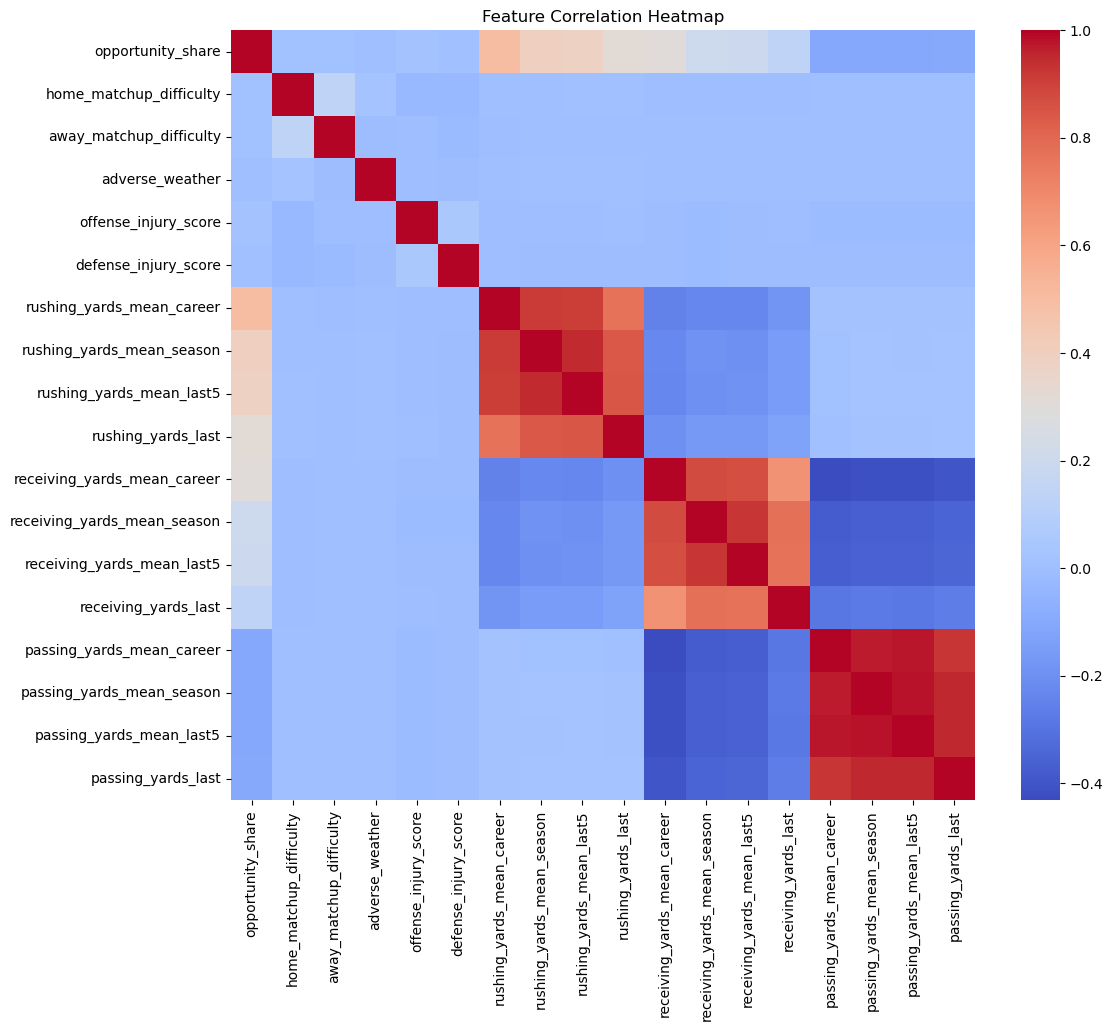

(                        Feature  Ranking
 0             opportunity_share        1
 12   receiving_yards_mean_last5        1
 11  receiving_yards_mean_season        1
 10  receiving_yards_mean_career        1
 16     passing_yards_mean_last5        1
 7     rushing_yards_mean_season        1
 8      rushing_yards_mean_last5        1
 1       home_matchup_difficulty        1
 6     rushing_yards_mean_career        1
 17           passing_yards_last        1
 2       away_matchup_difficulty        2
 13         receiving_yards_last        3
 9            rushing_yards_last        4
 14    passing_yards_mean_career        5
 5          defense_injury_score        6
 4          offense_injury_score        7
 15    passing_yards_mean_season        8
 3               adverse_weather        9,
                     Feature_1                  Feature_2  Correlation
 23   passing_yards_mean_last5  passing_yards_mean_season     0.980990
 20  passing_yards_mean_season   passing_yards_mean_last5  

In [104]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Recursive Feature Elimination (RFE)

# Initialize the Random Forest Regressor for RFE
rfe_model = RandomForestRegressor(random_state=42)
rfe = RFE(estimator=rfe_model, n_features_to_select=10)  # Select top 10 features

# Fit RFE to the training data
rfe.fit(X_train_numeric, y_train_)

# Get the rankings of features
rfe_rankings = pd.DataFrame({
    'Feature': X_train_numeric.columns,
    'Ranking': rfe.ranking_
}).sort_values(by='Ranking')

# Step 2: Correlation Analysis

# Compute the correlation matrix
correlation_matrix = X_train_numeric.corr()

# Plot the heatmap to visualize correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Identify highly correlated features (correlation > 0.8 or < -0.8)
high_correlation = correlation_matrix[(correlation_matrix.abs() > 0.8) & (correlation_matrix.abs() < 1.0)]
highly_correlated_pairs = high_correlation.stack().reset_index()
highly_correlated_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
highly_correlated_pairs = highly_correlated_pairs.sort_values(by='Correlation', ascending=False)

# Display RFE rankings and highly correlated feature pairs
rfe_rankings, highly_correlated_pairs.head(10)


### The grid search below is timing out, but I plan to troubleshoot it and fix the issue

In [ ]:
#This grid search code is timing out. I need to troubleshoot


# Simplified manual grid search
param_grid_manual = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 5, 10],
    'n_estimators': [25, 50, 100]
}

param_grid_refined = {
    'max_depth': [5, 15],
    'min_samples_split': [5, 15],
    'min_samples_leaf': [1, 5, 10],
    'n_estimators': [100, 200]
}

# Track the best parameters and corresponding RMSE
best_params = None
best_rmse = float('inf')

# Manual grid search loop
for max_depth in param_grid_manual['max_depth']:
    for min_samples_split in param_grid_manual['min_samples_split']:
        for min_samples_leaf in param_grid_manual['min_samples_leaf']:
            for n_estimators in param_grid_manual['n_estimators']:
                # Train the Random Forest model with the current parameters
                model = RandomForestRegressor(
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    n_estimators=n_estimators,
                    random_state=42
                )
                model.fit(X_train_numeric, y_train_)
                
                # Evaluate the model on the test data
                y_pred = model.predict(X_test_numeric)
                rmse = np.sqrt(mean_squared_error(y_test_, y_pred))
                
                # Update best parameters if the current RMSE is better
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = {
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf,
                        'n_estimators': n_estimators
                    }

# Output the best parameters and the corresponding RMSE
best_params, best_rmse


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid_manual = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 5, 10],
    'n_estimators': [50, 100, 200]
}

model = RandomForestRegressor(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid_manual,
    n_iter=20,  # Number of parameter combinations to try
    scoring= 'neg_mean_squared_error',
    cv=3,
    random_state=42,
    n_jobs=-1  # Use all available cores for parallel processing
)

# Randomized Search
random_search_2 = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid_manual,
    n_iter=20,  # Number of parameter combinations to try
    scoring= 'r2',
    cv=3,
    random_state=42,
    n_jobs=-1  # Use all available cores for parallel processing
)

random_search.fit(X_train_numeric, y_train_)

# Best parameters and RMSE
best_params = random_search.best_params_
best_rmse = np.sqrt(-random_search.best_score_)
best_params, best_rmse

#again for r^2
random_search_2.fit(X_train_numeric, y_train_)

# Best parameters and corresponding R^2
best_params_2 = random_search_2.best_params_
best_r2 = random_search_2.best_score_  # Mean R^2 across cross-validation folds
best_params_2, best_r2


In [ ]:
from sklearn.ensemble import VotingRegressor

# Define base models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)

# Ensemble
ensemble = VotingRegressor(estimators=[('rf', rf), ('xgb', xgb)])
ensemble.fit(X_train_numeric, y_train_)

# Predict and evaluate
y_pred_ensemble = ensemble.predict(X_test_numeric)
rmse_ensemble = np.sqrt(mean_squared_error(y_test_, y_pred_ensemble))
print("Ensemble RMSE:", rmse_ensemble)


In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error

# Generate predictions using the trained model
y_pred = model.predict(X_test_numeric)

# Create a DataFrame for results
results_df = pd.DataFrame({
    'Player': X_test['player_name'],
    'Player_ID': X_test['player_id'],
    'Position': X_test['position'],
    'Week': X_test['week'],
    'Rush Yards': X_test['week'],
    'Actual': y_test_,
    'Predicted': y_pred
})
results_df.to_csv('all_player_predictions_with_ids.csv', index=False)


# Optionally calculate error metrics for each player
results_df['Absolute_Error'] = abs(results_df['Actual'] - results_df['Predicted'])
results_df['Squared_Error'] = (results_df['Actual'] - results_df['Predicted']) ** 2

# Save to CSV
results_df.to_csv('model_predictions.csv', index=False)

print("Results saved to model_predictions.csv")


In [118]:
X_test_

position  opportunity_share  home_matchup_difficulty  \
58785       QB           0.001711                 0.100000   
59095       QB           0.001713                 0.071429   
59404       QB           0.001719                 0.142857   
59720       QB           0.001726                 0.090909   
60019       QB           0.001740                 0.500000   
...        ...                ...                      ...   
60018       RB           0.000047                 0.166667   
60557       RB           0.000071                 0.333333   
61182       RB           0.000084                 0.090909   
61481       RB           0.000087                 1.000000   
61749       RB           0.000111                 1.000000   

       away_matchup_difficulty  adverse_weather  offense_injury_score  \
58785                 0.071429                0                   1.0   
59095                 0.125000                0                   0.0   
59404                 0.076923                0                   6.0   
59720                 0.500000                0                   0.0   
60019                 0.083333                0                   1.0   
...                        ...              ...                   ...   
60018                 0.062500                0                   0.0   
60557                 0.166667                0                   5.0   
61182                 0.333333                0                   1.0   
61481                 0.500000                0                   6.0   
61749                 0.076923                0                   4.0   

       defense_injury_score  rushing_yards_mean_career  \
58785                   2.0                  14.943396   
59095                   0.0                  14.868545   
59404                   2.0                  14.803738   
59720                   0.0                  14.818605   
60019                   0.0                  14.870370   
...                     ...                        ...   
60018                   0.0                  10.333333   
60557                   3.0                  20.250000   
61182                   3.0                  21.400000   
61481                   4.0                  19.500000   
61749                   2.0                  22.000000   

       rushing_yards_mean_season  rushing_yards_mean_last5  \
58785                   0.000000                  5.400000   
59095                  -1.000000                  5.800000   
59404                   0.000000                  2.400000   
59720                   6.000000                  5.600000   
60019                  11.000000                  8.800000   
...                          ...                       ...   
60018                  10.333333                 10.333333   
60557                  20.250000                 20.250000   
61182                  21.400000                 21.400000   
61481                  19.500000                 20.800000   
61749                  22.000000                 26.200000   

       rushing_yards_last  receiving_yards_mean_career  \
58785                 0.0                    -0.051887   
59095                -1.0                    -0.051643   
59404                 1.0                    -0.051402   
59720                18.0                    -0.051163   
60019                26.0                    -0.050926   
...                   ...                          ...   
60018                 8.0                     4.000000   
60557                50.0                     3.000000   
61182                26.0                     2.400000   
61481                10.0                     2.000000   
61749                37.0                     4.285714   

       receiving_yards_mean_season  receiving_yards_mean_last5  \
58785                     0.000000                         0.0   
59095                     0.000000                         0.0   
59404                     0.000000             

In [181]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Define context fields and features
context_fields = [
    'season', 'week', 'position', 'recent_team', 'player_name', 'player_id',
    'attempts', 'completions', 'passing_tds', 'interceptions',
    'carries', 'receptions', 'rushing_tds', 'rushing_fumbles', 'rushing_yards', 'receiving_yards'
]

_features = [
    'opportunity_share', 'home_matchup_difficulty', 'away_matchup_difficulty',
    'adverse_weather', 'offense_injury_score', 'defense_injury_score', 
    'rushing_yards_mean_career', 'rushing_yards_mean_season', 'red_zone_carries', 
    'red_zone_targets', 'goal_line_carries', 'goal_line_targets', 
    'rushing_yards_mean_last5', 'rushing_yards_last', 'receiving_yards_mean_career', 
    'receiving_yards_mean_season', 'receiving_yards_mean_last5', 'receiving_yards_last', 
    'passing_yards_mean_career', 'passing_yards_mean_season', 'passing_yards_mean_last5', 
    'passing_yards_last'
]

# Combine features and context fields for the dataset
_data = dwf_[_features + context_fields + [target_]].dropna()

# Split the dataset into training and testing sets
train_data_, test_data_ = train_test_split_by_season(
    _data, test_season=2024, features=_features, target=target_
)

# Separate features and target for training and testing
X_train_ = train_data_.drop(columns=[target_])
y_train_ = train_data_[target_]
X_test_ = test_data_.drop(columns=[target_])
y_test_ = test_data_[target_]

# Apply one-hot encoding to the 'position' column in both train and test datasets
X_train_ = pd.get_dummies(X_train_, columns=['position','recent_team', 'player_name', 'player_id'], drop_first=True)
X_test_ = pd.get_dummies(X_test_, columns=['position','recent_team', 'player_name', 'player_id'], drop_first=True)

# Align the columns of the test set with the training set
X_test_ = X_test_.reindex(columns=X_train_.columns, fill_value=0)

# Retain a copy of the test data with context fields for the final output
context_test_data_ = test_data_[context_fields + [target_]]

# Train the Random Forest model
_model = RandomForestRegressor(random_state=42, n_estimators=100)
_model.fit(X_train_, y_train_)

# Make predictions
y_pred_ = _model.predict(X_test_)

# Combine predictions with context fields
results_df = pd.DataFrame({
    'Season': context_test_data_['season'],
    'Week': context_test_data_['week'],
    'Position': context_test_data_['position'],
    'Attempts': context_test_data_['attempts'],
    'Completions': context_test_data_['completions'],
    'Passing TDs': context_test_data_['passing_tds'],
    'Interceptions': context_test_data_['interceptions'],
    'Carries': context_test_data_['carries'],
    'Receptions': context_test_data_['receptions'],
    'Rushing Yards': context_test_data_['rushing_yards'],
    'Receiving Yards': context_test_data_['receiving_yards'],
    'Actual Fantasy Points': y_test_,
    'Predicted Fantasy Points': y_pred_
})

# Save the results to a CSV file
# results_df.to_csv('predictions_with_context.csv', index=False)
print(results_df.head())


      Season  Week Position  Attempts  Completions  Passing TDs  \
2215    2024     1       QB        21           13            1   
2216    2024     2       QB        30           18            2   
2217    2024     3       QB        35           27            2   
2218    2024     4       QB        42           24            0   
2219    2024     5       QB        54           29            2   

      Interceptions  Carries  Receptions  Rushing Yards  Receiving Yards  \
2215            1.0        1           0           -1.0              0.0   
2216            0.0        2           0            1.0              0.0   
2217            0.0        3           0           18.0              0.0   
2218            0.0        5           0           26.0              0.0   
2219            3.0        0           0            0.0              0.0   

      Actual Fantasy Points  Predicted Fantasy Points  
2215               8.580000                    8.2234  
2216              15.140000 

In [173]:
#Was working on getting the CSV output

Generate predictions using the trained model
y_pred = _model.predict(X_test_numeric_)
#test_data_
# Combine predictions with actual values and context
results_df = pd.DataFrame({
    'Season': test_data_['season'],    # Add season from the original test data
    'Week': test_data_['week'],        # Add week from the original test data
    'Position': test_data_['position'],
    'Attempts': test_data_['attempts'],
    'Completions': test_data_['completions'],
    'Passing TDs': test_data_['passing_tds'],
    'Interceptions': test_data_['interceptions'],
    'Carries': test_data_['carries'],
    'Rush Yards': test_data_['rushing_yards'],
    'Rush TDs': test_data_['rushing_tds'],
    'Targets': test_data_['carries'],
    'Receptions': test_data_['receptions'],
    'Receiving Yards': test_data_['receiving_yards'],
    'Receiving TDs': test_data_['receiving_tds'],
    'Fumbles': test_data_['rushing_fumbles'],
    'Actual': y_test,                # Actual values
    'Predicted': y_pred               # Predicted values
})

results_df.head()
Save to CSV
results_df.to_csv('all_player_predictions_with_week_season.csv', index=False)

print("Results saved to all_player_predictions_with_week_season.csv")


KeyError: 'attempts'